# Costa Rican Household Poverty Level Prediction 

이 _Costa Rican Household Poverty Prediction_ 의 목적은 가정의 빈곤 레벨을 예상하는 머신러닝을 개발하는 것입니다. 이 챌린지는 사람들이 광고를 클릭하게 만드는 것보다 사회의 발전을 위한 더 좋은 일을 합니다.   

이 노트북에서, 우리는 완성된 머신러닝 해결책을 만들것입니다.
1. 문제로 들어가기 : **Exploratory Data Analysus of Dataset, work on feature engineering, mutiple machine learning models**   
2. **select model**   
3. **optimize the model**    
4. **inspect the outputs of the model and draw conclusions**      

## Problem and Data Explanation 

제공된 데이터는 `train.csv`와 `test.csv`로 구성됐다.  training set은 9557 행과 143 columns을 가지고 있고 testing set은 23856행과 142 column을 가지고 있다. 각각 행은 **one individaul**을 나타내고 각각의 열은 **feature**이며 **either unique to the individual** 혹은 **for the household of the individual**이다. training set은 `TARGET`인 칼럼을 가지고 있고 이것은 빈곤의 레벨을 나타낸다.(1-4 scale) 1은 가장 극심한 빈곤을 나타낸다.    

This is a **supervised multi-class classification machine learning problem:**
  * **Supervised** : provided with the labels for the training data
  * **Multi-class classification** : Labels are discrete values with 4 classes 

### Objective (목표)
대회의 목표는 **가정 빈곤 수준**을 예측하는 것이다. 

> **Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0. We will cover how to correct this in the notebook** 

The `Target` values는 다음과 같은 level을 가지고 있다. :
1 =  극한의 빈곤
2 = 비교적 빈곤
3 = 경제적으로 취약한 가정
4 = 경제적으로 취약하지 않은 가정   

143 칼럼의 설명은 https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data 여기서 확인가능 하다.
* **Id** : 각 개인의 특별한 구분기호, 우리가 사용하는 특성이 되면 안된다.
* **idhogar** : 각 가정의 특별한 구분기호. 이 변수는 특성이 아니지만 id가 그랬던 것처럼 가정에 의한 그룹개인으로 사용가능하다.  
* **parentesco1** : 가정의 가장인지 표시
* **Target** :the label, which should be equal for all members in a household   

우리가 모델을 만들때 _the poverty level of the head of household_ 의 라벨과 함께 학습시킨다. 가공하지 않은 데이터는 a mix of both household and individual characteristics and for the individual data를 포함한다. 우리는 각 가정을 위해 이것을 집합시킬 방법을 찾아야 한다.  Some of the individuals belong to a household with _no head of household_ 이 의미는 안타깝게도 우리는 이 데이터를 학습에 사용시킬 수 없다. 데이터와 관련된 이 문제는 완전히 **실제-세계** 데이터와 닮았다. 그러므로 이 문제는 data science job의 좋은 대비가 될 것이다.  

### Metric 
궁극적으로 우리는 integer poverty level of a household를 예상하는 모델을 만드는 것이다. 우리 예측은 **Macro F1Score**에 의해 평가될 것이다. 우리가 익숙한 **Standard F1 Score**은 아래위 같다.
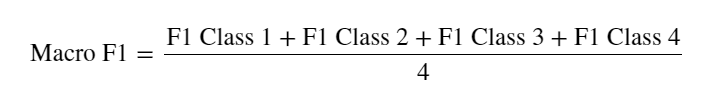
For multi-class problems, 우리는 각각 class를 위한 F1 score의 평균을 가진다.
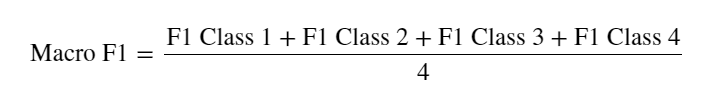
**macro F1은 각 모델의 F1을 평균낸다** _without taking into account label imbalances._
다른 말로, 각각의 라벨의 발생가능한 숫자는 calculation을 측정할 수 없다.   
the labels are imbalanced 문제는 macro averaging을 사용하는 것에 약간의 혼란을 준다. but that's a decision made by the organizers and not something we can change! In your own work, you want to be aware of label imbalances and choose a metric accordingly.

## Roadmap
1. 문제 이해하기
2. Exploartory Data Analysis
3. Feature Engineering 머신 러닝을 만들기 위해
4. 여러개의 baseline 모델과 비교하기
5. 좀 더 복잡한 모델을 시도하기
6. 선택된 모델 최적화
7. 문제에 대한 모델 예측치 재보기
8. 결론 이끌어내기 lay out next steps

# Getting Started
 we'll move into the Exploratory Data Analysis (EDA) and feature engineering.   
For EDA, 우리는 anomalies(이상치) 측정, trends, correlation, patterns를 측정한다. 이것은 feature engineering 과 modeling에 사용된다.    

## Imports 
We will use a familiar stack of adata science liabraries

In [1]:
# Data Manipulation
import pandas as pd 
import numpy as np 

#Visualiization 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Set a few plotting defaults 
%matplotlib inline 
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary Information 

In [2]:
pd.options.display.max_columns = 150

#Read in data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or ordinal variables with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Let's glance at the test data which has many more rows (individuals) than the train. It does have one fewer column because there's no Target!

### Integer Columns 
Integer columns의 unique value의 분배를 보자. -> bar plot으로 그려보자

Text(0.5, 1.0, 'Count of Unique Values in Interger Columns')

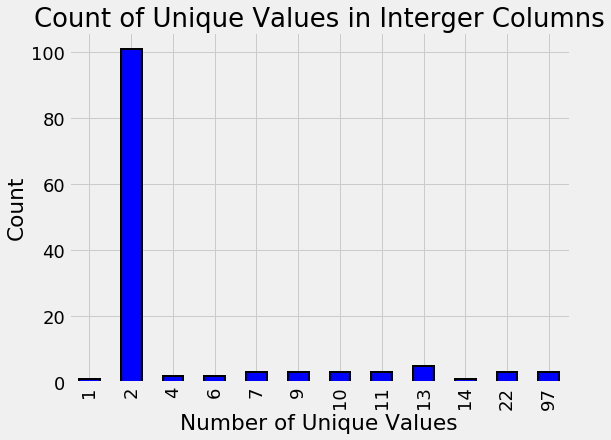

In [5]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Interger Columns')

오직 2개의 unique value를 가지고 있는 칼럼이 **Booleans(0 or 1)을 대표한다.** 많은 경우에, 이 boolean info는 이미 househole level이다.
예를 들어 `refrig` 칼럼은 가정이 냉장고를 가지고 있는지 아닌지를 나타낸다. 우리는 이 칼럼들을 합할 필요가 없다. 그러나 개인들의 레벨을 나타내는 Boolean 칼럼은 합해져야 한다.

### Float Columns 
float 칼럼은 연속 값을 나타낸다. 우리는 빠른 분포 plot를 그릴 수 있다. `OrderedDict`는 빈곤 수준을 색깔로 나타낸다. 왜냐면because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

다음 그래프는 `float` 칼럼들의 분포를 보여준다. `Target`에 의해 색칠된 /  이 plot과 함께 우리는 가정 빈곤 수준에 따른 심각한 분포 차이가 있는 지 확인할 수 있다. 

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

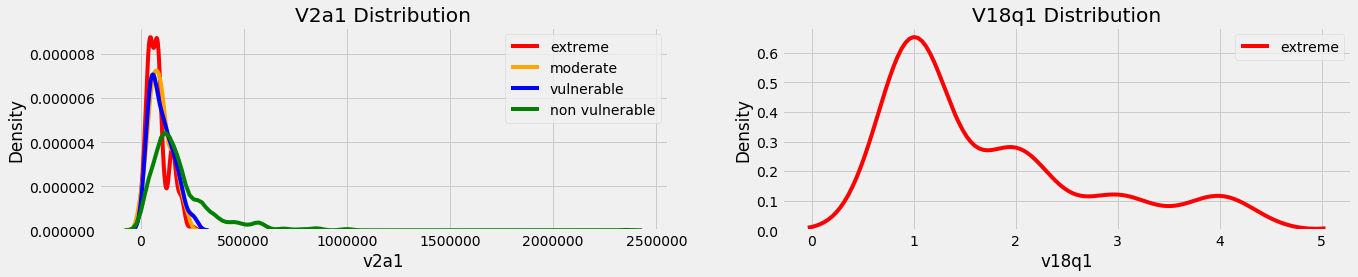

In [6]:
from collections import OrderedDict 

plt.figure(figsize=(20,16))
plt.style.use('fivethirtyeight')

#Color mapping 
colors = OrderedDict({1:'red',2:'orange',3:'blue',4:'green'})
poverty_mapping = OrderedDict({1:'extreme',2:'moderate',3:'vulnerable', 4:'non vulnerable'})

# Iterate through the float columns 
for i, col in enumerate(train.select_dtypes('float')) :
    ax = plt.subplot(4,2,i+1)
    #Iterate through the poverty levels 
    for poverty_level , color in colors.items() :
        #Plot each poverty level as a separte line 
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        plt.title(f'{col.capitalize()} Distribution')
        plt.xlabel(f'{col}');
        plt.ylabel('Density')
        
plt.subplots_adjust(top = 2)        

these plots can already give us a sense of which variables may be most "relevant" to a model.    
예를 들어 `meanduc`, 가정에서 성인 교육의 평균을 나타내는, 빈곤 수준과 연관되어 있다고 나타난다. : **성인 교육 평균이 높을 수록 높은 target값과 연관되어 있다. 즉 더 낮은 빈곤 수준과 연관된다.**  

### Object Columns 


In [7]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


* `dependency` : Dependency rate, calculated = (19보다 어리고 64보다 나이든 가족 수) /(19 ~64 사이 가족 수)
* `edjefe` : 가정의 남자 대표의 교육 년수. based on the interaction of escolari(교육 년수), 가족 대표와 성별 yes = 1, no = 0
* `edjefa` : 가족 여성 대표 교육 년수. 여자면 1 아니면 0 
공통 사항으로서 **yes = 1 , no = 0**     
우리는 mapping과 float으로 변환을 통해 정확히 할 수 있다. 

In [8]:
mapping = {'yes' : 1, 'no' :0}

#Apply same operation to both train and test 
for df in [train, test] :
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    
train[['dependency','edjefa','edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


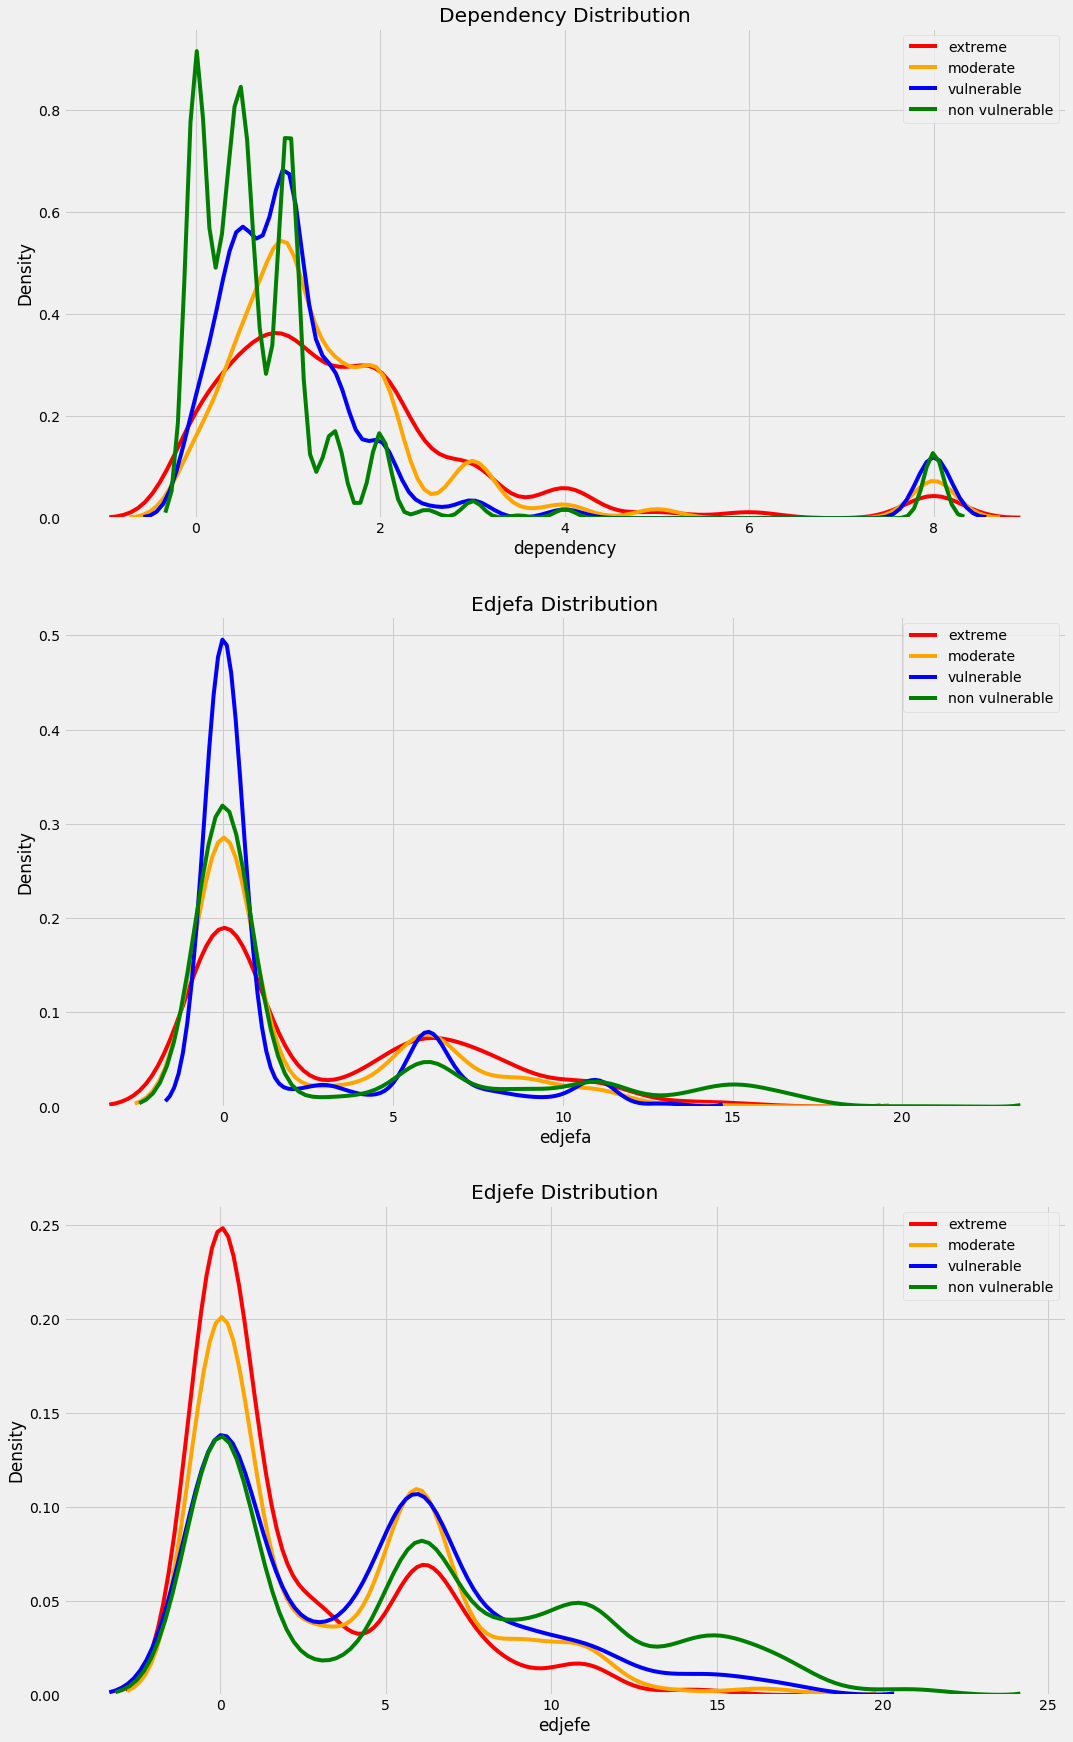

In [9]:
plt.figure(figsize=(16,12))

#Iterate through the float columns 
for i , col in enumerate(['dependency','edjefa','edjefe']) :
    ax = plt.subplot(3,1,i+1)
    #Iterate through the poverty levels 
    for poverty_level, color in colors.items():
        #Plot each poverty level as a separte line 
        sns.kdeplot(train.loc[train['Target']==poverty_level,col].dropna(),
                   ax = ax, color = color, label = poverty_mapping[poverty_level])
                
    plt.title(f'{col.capitalize()} Distribution') 
    plt.xlabel(f'{col}') 
    plt.ylabel('Density')
    
plt.subplots_adjust(top = 2)

이 변수들은 현재 숫자들을 정확히 대표하고 있고 모델에 input할 수 있다.    
좀 더 쉽게 운영하기 위해, 우리는 training 과  testing을 합한다. 이것은 feature engineering을 시작할때 중요하다.   
왜냐하면 우리는 같은 공식을 대입하고 싶기 때문이다. 그래서 우리는 같은 feature을 이끌어낼 수 잇다? 그 후 우리는 `Target`을 분리시킨다. 

In [10]:
# Add null Target column to test 
test['Target'] = np.nan 
data =train.append(test, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33413 entries, 0 to 33412
Columns: 143 entries, Id to Target
dtypes: float64(12), int64(129), object(2)
memory usage: 36.5+ MB


### Exploring Label Distribution 
다음으로, 우리는 어떻게 불균형 문제를 라벨 분포를 봄으로써 해결할껀지 아이디어를 얻을 수 있다. 4개의 integer level이 있다. 정확한 라벨을 보기 위해 우리는 한 개의 칼럼을 뺀다. `parentesco1 == 1 `왜냐면 가정의 대표이고, 각각의 가정 라벨과 정확하므로?      

bar plot은 training label의 분포를 보여준다. (no testing label)

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

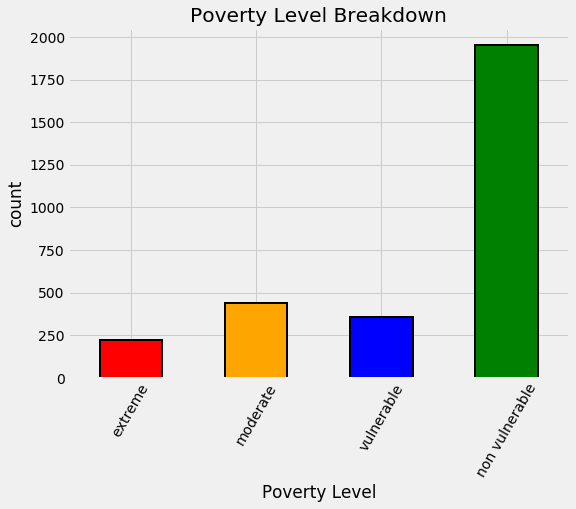

In [11]:
#Heads of household 
heads = data.loc[data['parentesco1']==1].copy()

#Labels for training 
train_labels = data.loc[(data['Target'].notnull())&(data['parentesco1']==1),
                       ['Target','idhogar']]

#Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

#Bar plot of occurrences of each label 
label_counts.plot.bar(figsize = (8,6),
                     color = colors.values(),
                     edgecolor = 'k',linewidth= 2)

#Formatting 
plt.xlabel('Poverty Level')
plt.ylabel('count')
plt.xticks([x-1 for x in poverty_mapping.keys()],
          list(poverty_mapping.values()),rotation= 60)
plt.title('Poverty Level Breakdown')

label_counts 

우리는 이 불균형한 class problem을 다룰것입니다. (왜 F1 을 썼는지 생각해봐~) 카테고리에 _non vulnerable_ 이 많다. **the extreme poverty class is the smallest!**   
하나의 잠재적인 방법은 oversampling하는 것입니다.(extreme)

## Addressing Wrong Labels 
Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. 이 문제에서는 일부 라벨은 정확하지 않습니다. 왜냐하면 _individuals in the same household have a different poverty level_ 우리는 가정의 대표를 사용하는게 진정한 라벨입니다. ?    ?   ?    

### Identify Errors 
우선, 우리는 에러를 찾아야 합니다. 가정이 다른 라벨인 것에 대해, 우리는 가정으로 그룹화 할 수 있습니다. then check if there is only one unique value of the `Target`.

In [12]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [13]:
#Lets look at one exam
train[train['idhogar']==not_equal.index[0]][['idhogar','parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


`parentesco1 == 1`일때 가정의 대표가 정확하다. 이 가정에서는 정확한 라벨이 **3**이어야 한다. 모든 구성원들에게. 우리는 정확한 빈곤수준을 개인에게 재부여함으로써 고칠 수 있다. 

### Families without Heads of Household 
만약에 대표가 없는 가정은 어떡하지? 그리고 다른 라벨을 가지고 있으면 어떡하지?    
let's incestigate exactly that question! 

In [14]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

#Find households without a head 
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader==0].index),:]

print('There are {} households without a head'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head


In [15]:
#Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x : x.nunique()==1)
print('{} Households with no head have different labels'.format(sum(households_no_head_equal==False)))

0 Households with no head have different labels


우리는 household 에 대한 문제를 걱정할 필요가 없습니다. 다른 라벨을 가지는 멤버가 없습니다. 이 문제는 **만약 가정의 대표가 없다면, 진실된 라벨이 없습니다. 그러므로 우리는 실제로 대표가 없는 가정 데이터를 사용하지 않습니다.**  

### Correct Errors 
Now we can correct labels for the households that do have a head AND the members have different poverty levels.

In [16]:
# Iterate through each household 
for household in not_equal.index :
    #Find the correct label  (for the head of household)
    true_target = int(train[(train['idhogar']==household)&(train['parentesco1']==1.0)]['Target'])
    
    #Set the correct label for all members in the household
    train.loc[train['idhogar']==household, 'Target']= true_target
    
#Groupby the household and figure out the number of unique value
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)

#Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the famliy members do not all have the same target'.format(len(not_equal)))

There are 0 households where the famliy members do not all have the same target


우리가 가정의 대표의 라벨을 사용하므로, **이 단계는 완전히 필요하진 않지만 그래도 데이터 에러를 고치는 일의 작업을 보여줍니다.** 

## Missing Variables 
One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them.    

우선, 우리는 각 칼럼의 missing value 퍼센트를 봅니다. 

In [17]:
#Number of missing in each column 
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0:'total'})

#Create a percentage missing 
missing['percent'] = missing['total']/len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


우리는 `Target`에 대해 걱정할 필요가 없습니다. 왜냐하면 우리는 `NaN`을 test data에 만들었기 때문입니다. 그러나 우리는 3개의 컬럼의 높은 missing value를 처리해야 합니다.

**v18q1** : Number of tablets  (PC)    
Since this is a household variable, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.   

### Function to Plot value Counts 


In [18]:
def plot_value_counts(df, col, heads_only = False) :
    """Plot value counts of a column, optionally with only the head"""
    #Select heads of household
    if heads_only :
        df = df.loc[df['parentesco1']==1].copy()
        
    plt.figure(figsize = (8,6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                edgecolor = 'k',
                                                linewidth = 2)
    plt.xlabel(f'{col}')
    plt.title(f'{col} Vaue Vounts')
    plt.ylabel('count')
    plt.show()

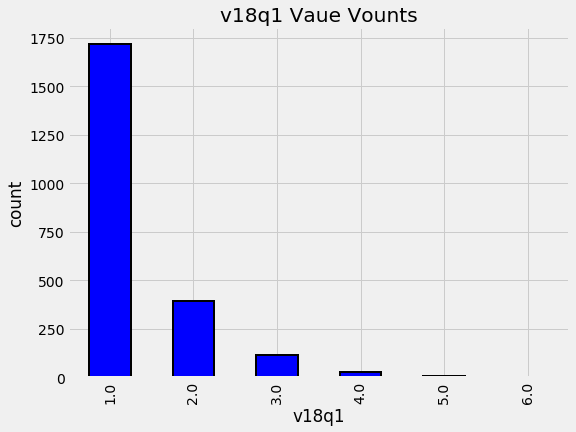

In [19]:
plot_value_counts(heads,'v18q1')

대부분의 가정이 tablets을 1개 갖고 있는것 처럼 보인다. 그러나 우리는 missing data를 생각해야만 한다. 이 경우에, `nan` data가 table이 없는 가정일 수도 있다! 마약 우리가 data 정의를 보려면, 우리는 `v18q`가 가정이 태블릿을 소유하는지 아닌지로 봐야한다.

We can groupby the value of `v18q` (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for `v18q1`. This will tell us if the null values represent that the family does not own a tablet.

In [20]:
heads.groupby('v18q')['v18q1'].apply(lambda x :x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

모든 가정이 `nan` for `v18q1`이 태블릿을 소유하고 있지 않다. 그러므로 우리는 missing value를 0으로 채울 수 있다. 

In [21]:
data['v18q1'] = data['v18q1'].fillna(0)

**v2a1** : 매월 월세 대금 

v2a1의 missing value를 보기 위해, `tipovivi_`의 분배를 보는 것이 좋다. 이 칼럼은 집의 소유/대여 상태를 보여준다. for this plot, 우리는 그들의 집의 소유를 `nan`과 함께 볼 수 있다. 

Text(0.5, 1.0, 'Home Ownership Status for Households Missing Rent Payments')

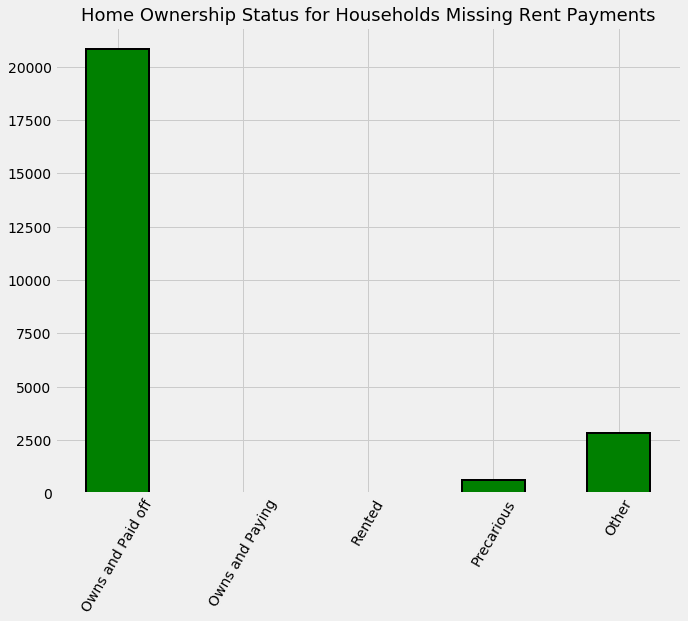

In [22]:
#Variables indication home ownership 
own_variables = [x for x in data if x.startswith('tipo')]

#Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(),own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2)
plt.xticks([0,1,2,3,4],
          ['Owns and Paid off','Owns and Paying','Rented','Precarious','Other'],
         rotation= 60 )
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18)

the meaning of the home ownership variables is below :
  * tipovivi1, = 1 own 그리고 완전히 자가 
  * tipovivi2 = 1 own 그리고 갚고 있는 중
  * tipovivi3 = 1 rented(전세?)
  * tipovivi4 = 1 precarious
  * tipovivi5 = 1 other(assigned, borrowed)   
  
소유한 집이 missing 값을 가지고 있을 때, 우리는 rent payment를 0으로 설정할 수 있다. 다른 집들은 missing value 그대로 냅둔다. 그러나 flag(boolean)을 남긴다.   

In [23]:
#Fill in households that own the house with 0 rent payment 
data.loc[(data['tipovivi1']==1),'v2a1'] =  0

#Create missing rent payment column 
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

**rez_esc** : years behind in school (졸업 한 후 몇년?)   
높은 missing value를 가지고 있는 마지막 열은 `rez_esc`이다. null 값을 가지고 있는 가족은 아마도 현재 학교에 아이들이 없을 것이다.    
missing value를 가지고 있는 열의 나이를 missing value가 없는 열의 나이와 비교해보자! 

In [24]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

missing value와 있는 가장 늙은 나이는 **17**이다. 이보다 더 큰 나이는 아마 학교에 없을 것이라고 예측할 수 있다. 

In [25]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

대회 규칙에 따르면, 이 변수는 오직 7 ~ 19살만 정의됐단 것을 알것이다. 그러므로 이 값은 0이 되어야 한다.     
For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.  

In [26]:
# if individaul is over 19 or younger than 7 and missing years, set it to 0
data.loc[((data['age']>19) | (data['age']<7)) & (data['rez_esc'].isnull()),'rez_esc']=0

# Add a fla for those between 7 and 19 with a missing value 
data['rez_esc-missing'] = data['rez_esc'].isnull()

물론 `rez_esc`역시 이상치가 있습니다. 다시, 대회 규칙에 따르면 이 변수의 가장 큰 값이 5라는 것을 알 수 있습니다.   
**그러므로 5를 넘는 값은 5로 맞춰줍니다**

In [27]:
data.loc[data['rez_esc']>5,'rez_esc']=5

## Plot Two Categorical Variables 

categorical 변수들이 서로 어떻게 영향을 끼치는 지 봅니다. 

In [28]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

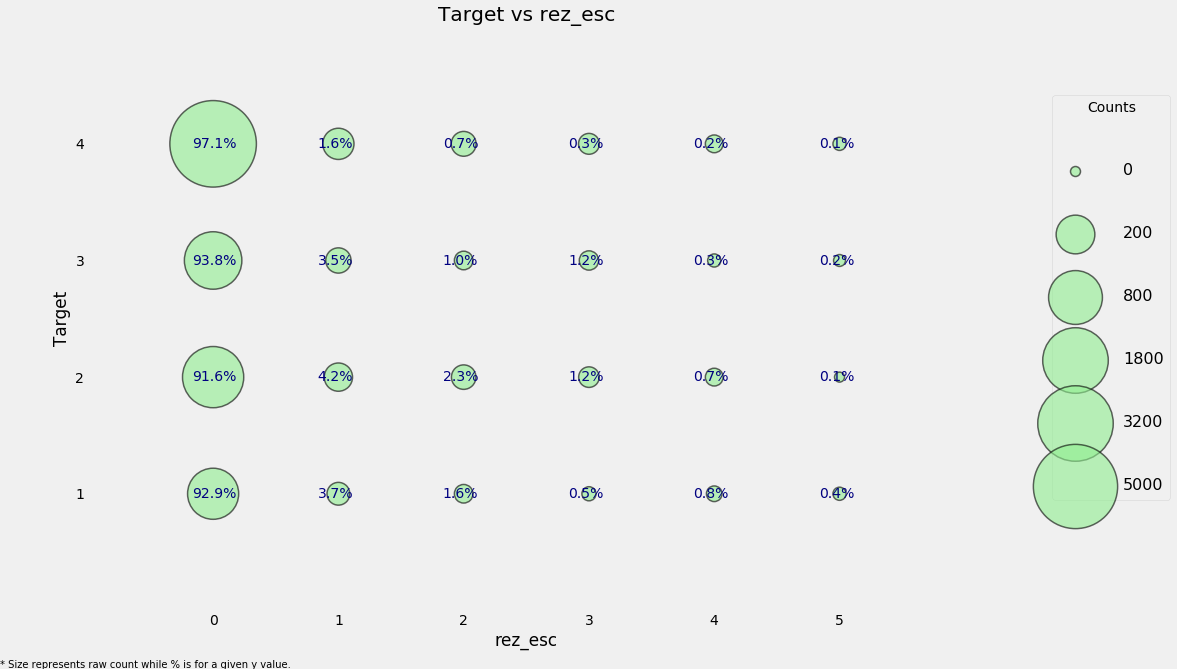

In [29]:
plot_categoricals('rez_esc','Target',data)

marker의 사이즈는 raw count를 나타낸다. 이 plot을 읽기 위해, 주어진 y값을 선택하고 행을 넘겨 읽는다. 예를 들어 poverty level = 1, 93%의 개인이 약 800 명이 no years behind이며, 0.4%의 개인(50명)이 5년을 넘었다. This plot attempts to show both the overall counts and the within category proportion   

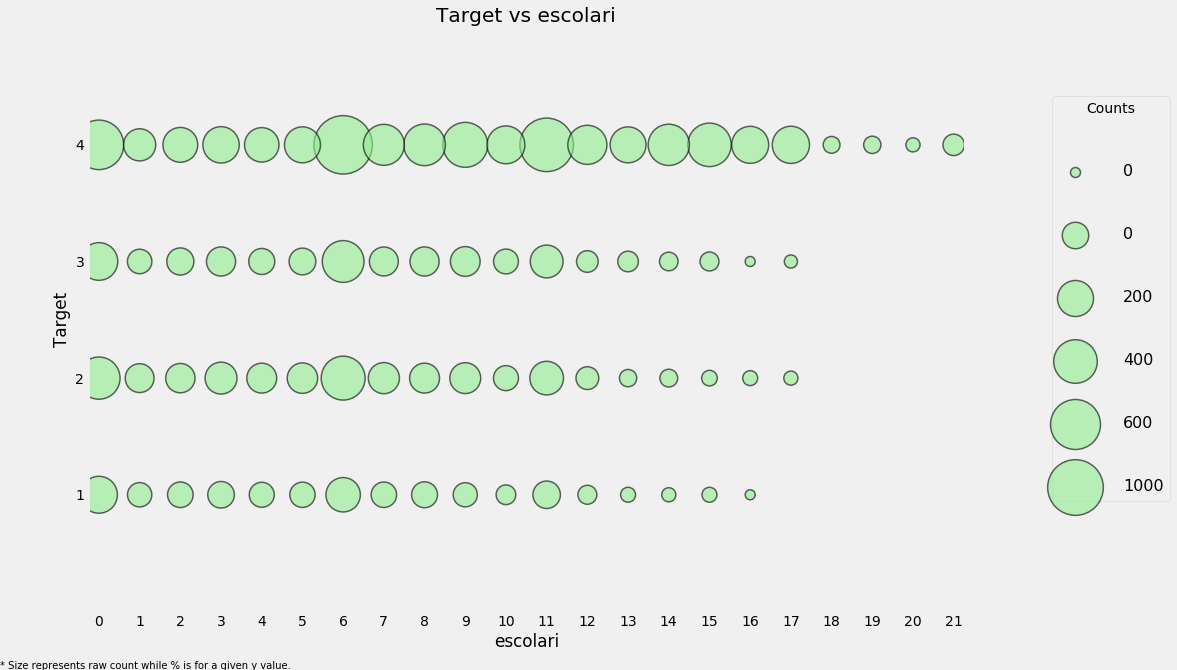

In [30]:
plot_categoricals('escolari','Target',data,annotate=False)

`Imputation` 과정을 통해 현재 missing value는 각각의 칼럼에 차있다. imputation의 여러 과정이 있으며 가장 심플하고 효과적인 방법은 `median`으로 채우는 것이다.    

그리고 missing value의 마지막 step으로 우리는 target의 분포를 그릴 수 있다. 어디에 missing value가 있는 지 

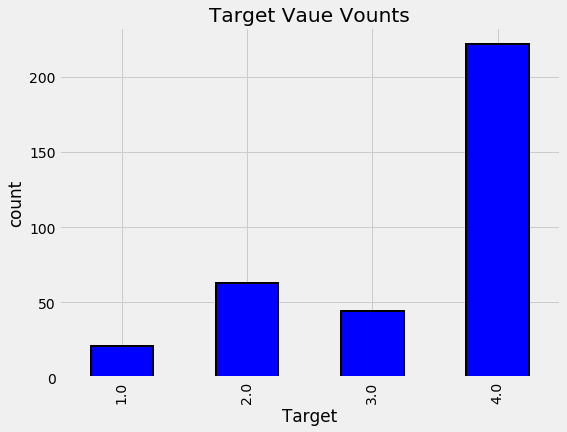

In [31]:
plot_value_counts(data[(data['rez_esc-missing']==1)],
                 'Target')

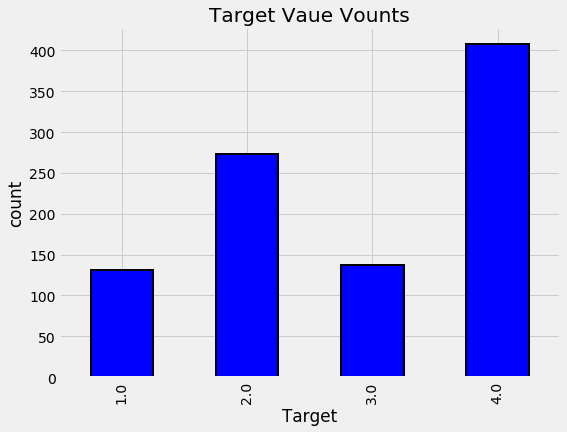

In [32]:
plot_value_counts(data[(data['v2a1-missing']==1)],'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty.

**This represents an important point:** sometimes the missing information is just as important as the information you are given

# Feature Engineering 
첫번째로 우리는 household level에서 우리 데이터를 굳건히 해야한다. 우리는 이미 각각의 가정의 정보를 갖고있다. 그러나 학습에 있어서 우리는 각 가정의 요약된 _모든_ 정보가 필요하다. 이것은 개인을 집으로 `groupby`해야 하고 `agg`해야 함을 의미한다.   

In another notebook, I show how we can use automated feature engineering to do this, and **automated feature engineering** should be a standard part of the machine learning workflow. Right now, we'll stick to doing this by hand, but definitely take a look at **automated feature engineering in Featuretools.**

## Column Definitions 

과정은 아래와 같다.
1. 변수들을 household level과 individidual level로 부순다.
2. individual level 을 위해 적합한 합한 과정을 취한다. 
   * Ordinal 변수들은 statistical 합산을 취한다.
   * Boolean 변수또한 합하지만 좀더 적게 
3. individual 합함을 houshold level data에 join한다.

### Define Variable Categories 
1. Individual Variables : 
   * Boolean : Yes or No (0 or 1)
   * Ordered Discrete : 순서가 있는 Integers
2. Household variables :
   * Boolean : Yes or No
   * Ordered Discrete : 순서가 있는 Integers
   * Continuous numeric
3. Squrared Variables : derived from squaring variables in the data
4. Id variables : 데이터를 구분하고 피처화 될 수 없다.  

In [33]:
id_ = ['Id','idhogar','Target']

In [34]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [35]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [36]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Let's make sure we covered all of the variables and didn't repeat any.

In [37]:
x = ind_bool + ind_ordered + id_ + hh_bool +hh_ordered + hh_cont + sqr_

from collections import Counter 

print('There are no repeats :',np.all(np.array(list(Counter(x).values()))==1))
print("We covered every variables ",len(x) == data.shape[1])

There are no repeats : True
We covered every variables  True


### Squared Variables
우선, 가장 쉬운 step : 모든 squared 변수들을 지운다.  
가끔 변수들이 곱해지거나 feature engineereing 과정 중 하나로 변한다. 왜냐하면 이것이 선형 모델로 되는 것에 도움이 되기 때문이다. 그러나 우리는 복잡한 모델을 사용할 것이기 때문에, 이 곱셈 피처들은 redundant한다.   
예를 들어 `SQBage` vs `age`를 보자  

Text(0.5, 1, 'Squared Age vs Age')

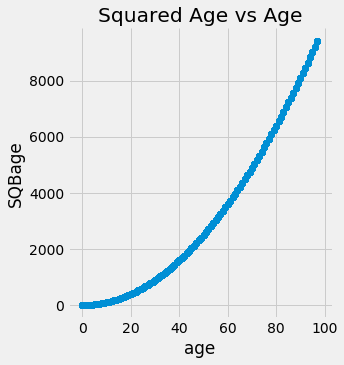

In [38]:
sns.lmplot('age','SQBage',data = data, fit_reg = False)
plt.title('Squared Age vs Age')

이 변수들은 높은 상관관계를 보인다. 둘 다 데이터에 있을 필요는 없다. 

In [39]:
#Remove squred variabels
data =data.drop(columns=sqr_)
data.shape

(33413, 136)

## Id Variables 
확인을 위해 그대로 냅둔다   

## Household Level Variables 
우선 heads of household를 뺀다. 그 후 household level 변수를 본다. 

In [40]:
heads = data.loc[data['parentesco1']==1,:]
heads = heads[id_ +hh_bool +hh_cont + hh_ordered]
heads.shape

(10307, 99)

household level 변수들을 위해 우리는 이렇게 한다. :   
우리는 각각의 가정에 대해 예측하고 싶기 때문에, 이 변수들을 피처로 사용한다. 그러나, 불필요한 변수들을 지우고 다른 피처를 붙일 수 있다.   

### Redundant household Variables 
모든 가정 변수들의 상관관계를 보자. 너무 높은 상관관계가 있다면 우리는 짝 중 하나를 지울 것이다.  

In [41]:
#Create correlation matrix 
corr_matrix = heads.corr()

#Select upper triangle of corr matrix 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

#Find index of feature columns with correlation grether than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column])>0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

위 변수들은 상관관계 변수들의 짝 중 하나를 보여준다. 다른 짝을 찾기 위해, 우리는 `corr_matrix`를 뺀다.?

In [42]:
corr_matrix.loc[corr_matrix['tamhog'].abs()>0.9,corr_matrix['tamhog'].abs()>0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


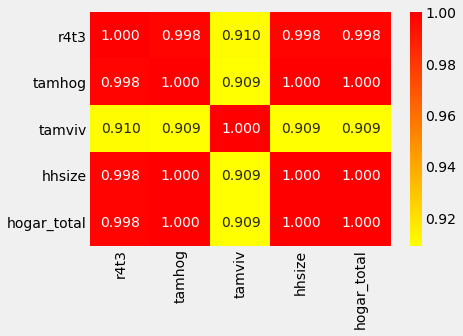

In [43]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

There are several variables here having to do with the size of the house:
   * r4t3, Total persons in the household
   * tamhog, size of the household
   * tamviv, number of persons living in the household
   * hhsize, household size
   * hogar_total, # of total individuals in the household
   
이 변수들은 서로 높은 상관관계를 가진다. 실제로 `hhsize`는 `tabhog`와 `hogar_total`과 완벽한 상관관계를 가진다. 우리는 이2개의 변수를 지운다. 또한 `r4t3`도 지운다. 왜냐하면 `hhsize`와 완벽한 상관관계를 갖기 때문에   

`tamviv`는 `hhsize`와 완전히 같은 것은 아니다. 왜냐하면 집에 살고있지 않는 식구가 있을 수도 있기 때문에   
이 차이점을 scatterplot으로 visualize해보자! 

In [44]:
heads =heads.drop(columns = ['tamhog','hogar_total','r4t3'])

C:\Study\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1, 'Household size vs number of persons living in the house')

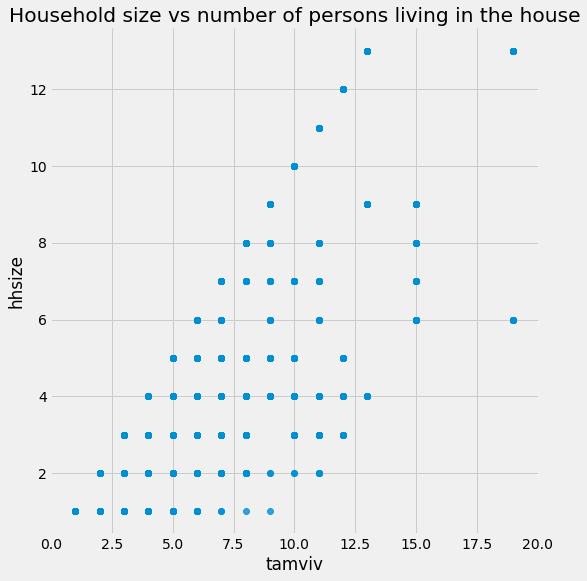

In [45]:
sns.lmplot('tamviv','hhsize',data,fit_reg=False, size = 8)
plt.title('Household size vs number of persons living in the house')

케이를 보면 알다 싶이, 가족보다 같이 사는 가정이 더 많다. 이것은 우리 새로운 피처의 아이디어를 준다 : **the difference between these two measurements!**  

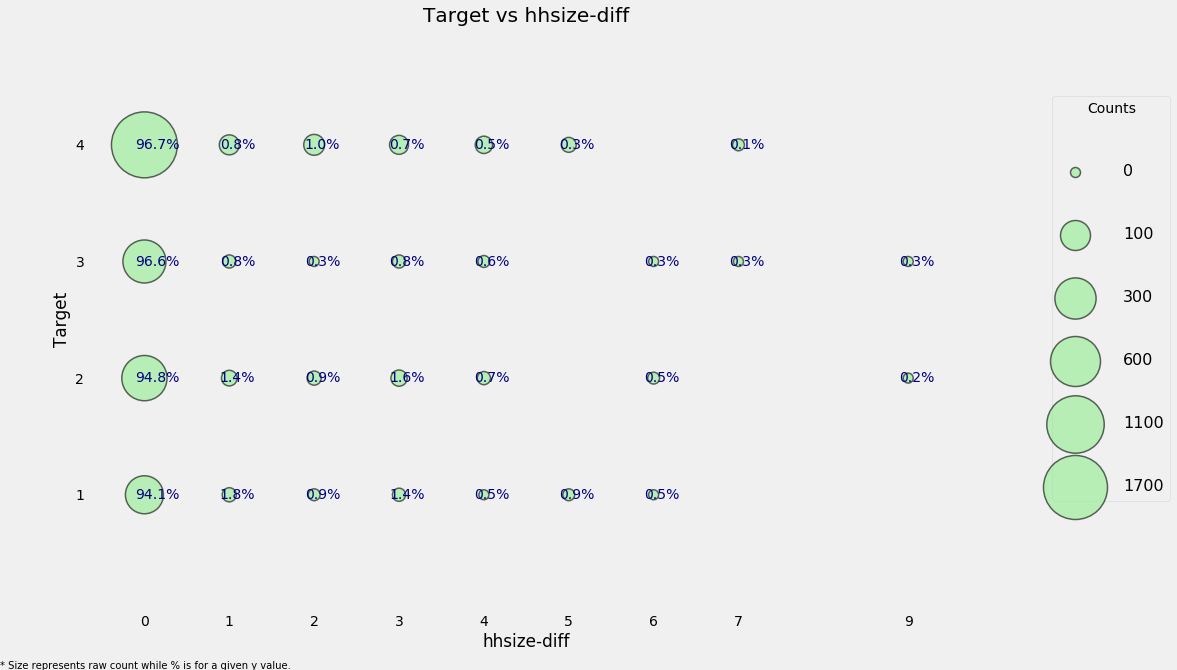

In [46]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff','Target',heads)

비록 대부분의 가정이 차이가 없더라고, 가족 구성원보다 더 많은 사람들이 집에 살고 있다.    
불필요한 변수들을 보자! `coopele`

In [47]:
corr_matrix.loc[corr_matrix['coopele'].abs()>0.9,corr_matrix['coopele'].abs()>0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수들은 집 안의 전기가 어디서 들어오는지? 알려준다.   
4개의 옵션이 있다. 전기 없음 -> `noelec` , 사적 공장 -> `planpri` 

### Creating Ordinal Variable 
* 0: No electricity
* 1: Electricity from cooperative
* 2: Electricity from CNFL, ICA, ESPH/JASEC
* 3: Electricity from private plant

순서가 있는 변수들은 inherent ordering이다. 이것은 우리 도메인 지식에서 얻을 수 있다. 새로운 순서가 있는 변수들을 만든 후, 우리는 4개를 드랍시킬 수 있다. 이 변수를 가지지 못한 여러 가정이 있으므로 우리는 `nan`을 사용하고 boolean 칼럼을 추가한다.

In [48]:
elec = []

#Assign values 
for i, row in heads.iterrows() :
    if row['noelec'] == 1 :
        elec.append(0)
    elif row['coopele'] == 1 :
        elec.append(1)
    elif row['public'] == 1 :
        elec.append(3)
    else :
        elec.append(np.nan)
        
#Record the new variable and missing flag
heads['elec'] = elec 
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

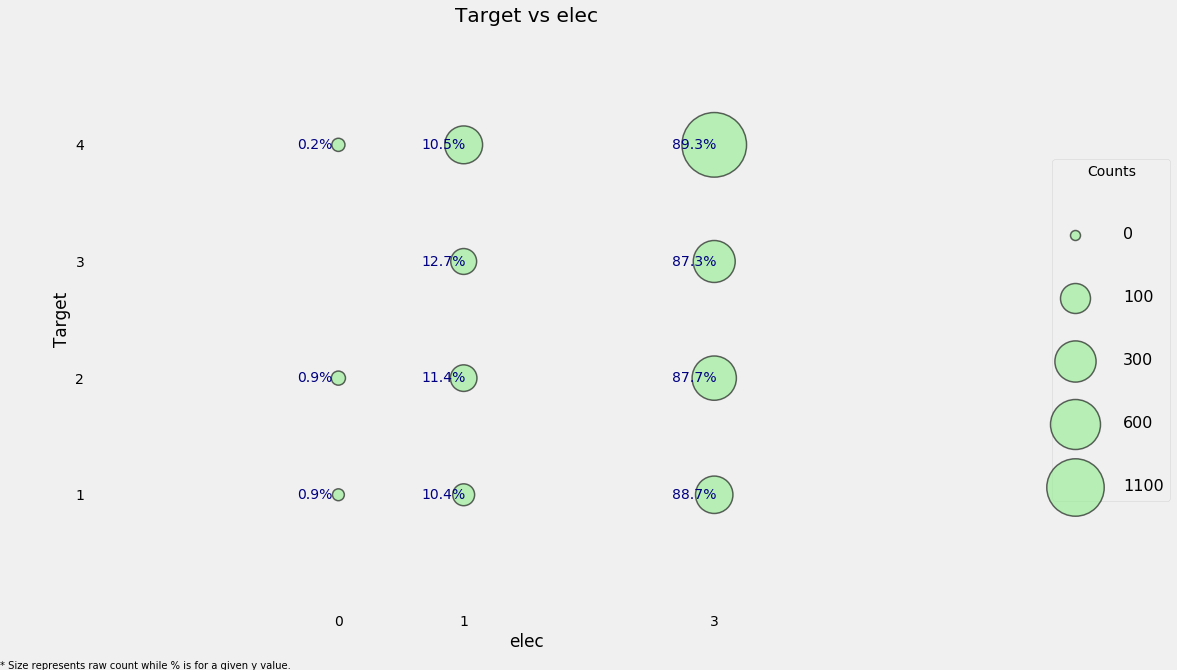

In [49]:
plot_categoricals('elec','Target',heads)

우리는 Target의 모든 값을 볼 수 있습니다. 대부분의 전기 공급은 public에서 옵니다.   


마지막 불필요한 칼럼은 `area2`입니다. 이것은 집이 외곽(시골)에 있는지 여부를 나타냅니다. 우리는 집이 도시에 있는지 나타내는 변수가 잇기 때문에 이 칼럼은 필요없습니다. 그러므로 드랍합니다.

In [50]:
heads = heads.drop(columns='area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

### Creating Ordinal Variables 

벽, 지붕, 바닥을 위해서 3개의 칼럼이 있습니다. 'bad','regular','good'. 우리는 이 변수들을 boolean으로 남길 수 있습니다. 그러나 ordinal variable로 나타내는 게 더 좋아보입니다. : `bad < regular < good`  이렇게 하기 이해서 non-zero인 칼럼이 무엇이든 `np.argmax`를 사용합니다.   

Once we have created the ordinal variable, we are able to drop the original variables.

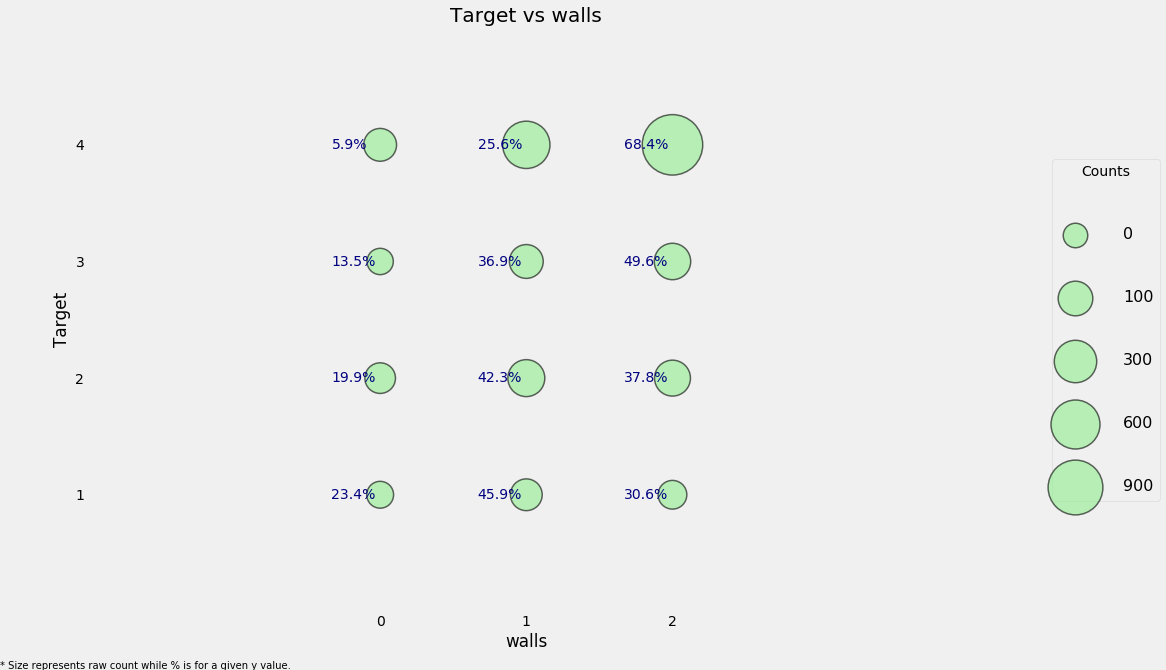

In [51]:
# Wall ordinal variable 
heads['walls'] = np.argmax(np.array(heads[['epared1','epared2','epared3']]),axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls', 'Target', heads)

In [52]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

## Feature Constriction 
변수들을 ordinal feature에 매핑하기 위해서 우리는 완전히 새로운 피처를 만들 수 있습니다. 예를 들어 우리는 이전 3개의 피처를 집의 전반적인 퀄리티의 측정으로 만들수 있습니다. 

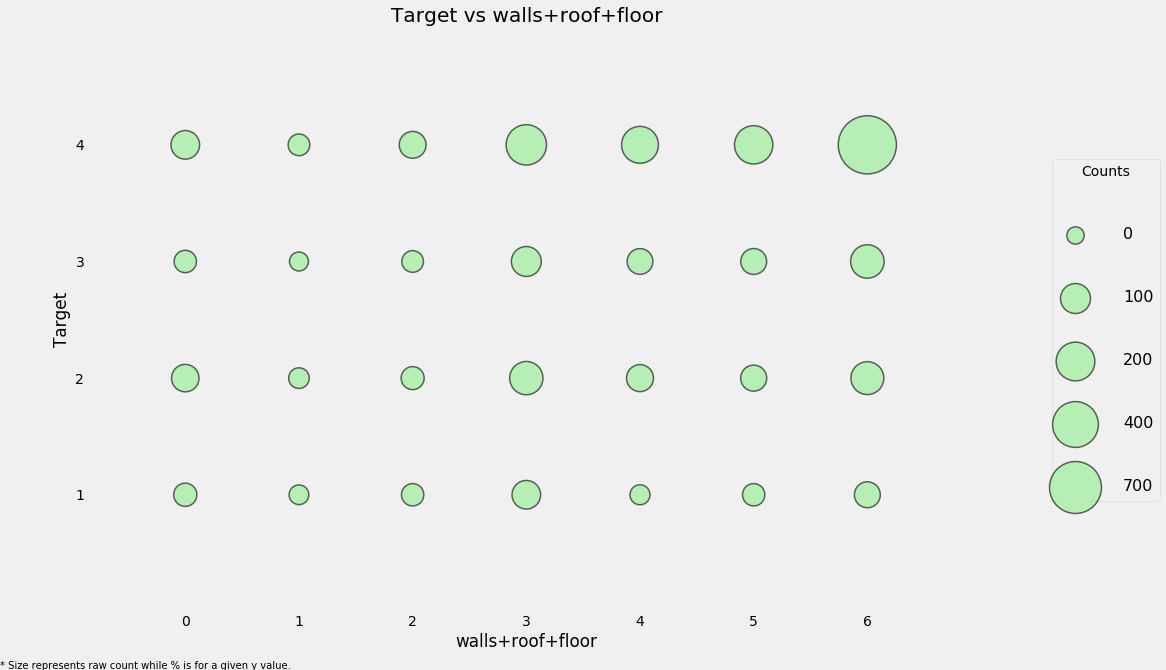

In [53]:
# Create new feature 
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor','Target',heads,annotate=False)

이 새로운 피처는 유용할 수 도 있습니다. Target of 4와 house quality가 연관있어 보입니다. 

In [54]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target':'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


다음 변수는 집의 퀄리티에 대한 `warning` 입니다. 이것은 - 값 처럼 보이지만, -1 point는 각각 화장실, 전기, 바닥, 물, 천장 이 없는 것을 의미합니다 

In [55]:
#No toilet, electricity, floor, water service, ceilling 
heads['warning'] = 1 *(heads['sanitario1'] + 
                      (heads['elec']==0)+
                      heads['pisonotiene'] +
                      heads['abastaguano'] + 
                      (heads['cielorazo']==0))

우리는 `plot_categoricals` 함수를 이 관계를 그려내기 위해 계속 사용합니다. 그러나 `seaborn` 또한 많은 plotting 옵션이 있습니다. `violinplot` 중 하나는  y axis 에 따른 분포를 보여줍니다. 

Text(0.5, 1.0, 'Target vs Warning Variable')

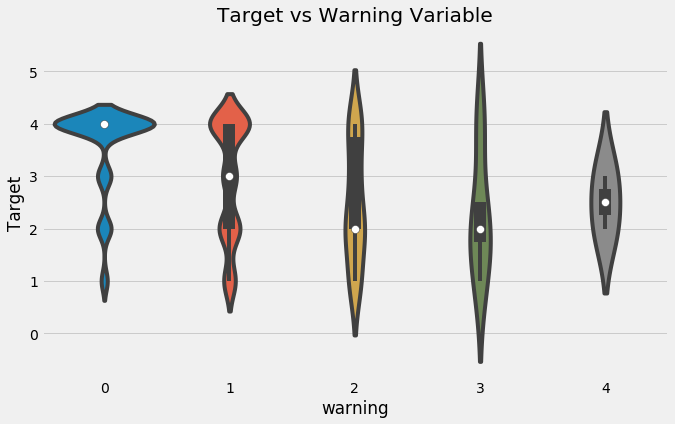

In [56]:
plt.figure(figsize = (10,6))
sns.violinplot(x = 'warning',y='Target',data = heads)
plt.title('Target vs Warning Variable')

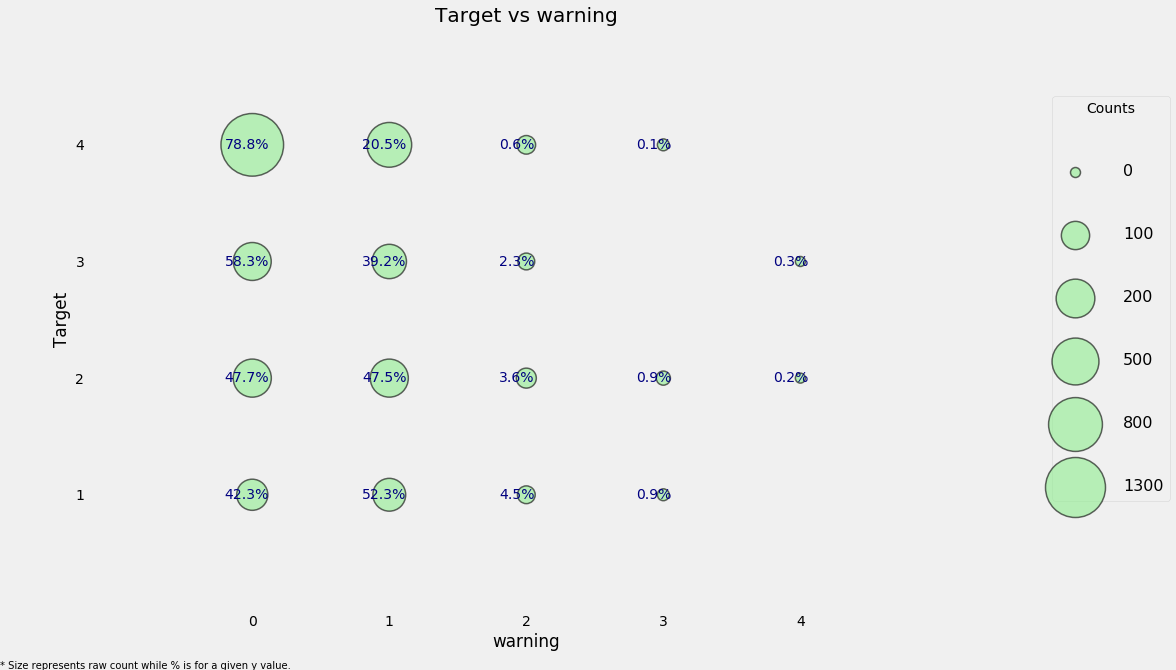

In [57]:
plot_categoricals('warning','Target',data = heads)

우리는 높은 가정의 집중을 볼 수 있다. ( warning signs이 없는 그리고 가장 낮은 수준의 빈곤 ). 쓸모 있는 피처인 것 처럼 보이지만, modeling까지 할 지는 잘 모르겠습니다!    

마지막 집 피처는 `bonus`입니다. 집이 냉장고, 컴퓨터, pc or tv를 가지고 있는지 알려줍니다. 

Text(0.5, 1.0, 'Target vs Bonus Variable')

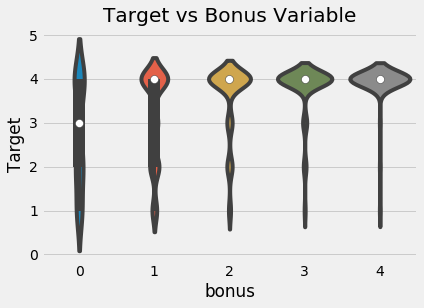

In [58]:
#Owns a ref , computer, tablet and tv
heads['bonus'] = 1 *(heads['refrig']+
                    heads['computer'] + 
                    (heads['v18q1']>0) +
                    heads['television'])

sns.violinplot('bonus','Target',data= heads, figsize = (10,6))
plt.title('Target vs Bonus Variable')

## Per Capita Features 

In [59]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploting Household Variables 

### Mesuring Relationships 
두 변수간 관계를 측정하는 많은 방식들이 있습니다 : 
  1. The Pearson Correlation : -1 부터 1까지 선형 관계를 측정
  2. The Spearman Correlation : -1 부터 1까지 monotonic관계를 측정 

Spearman 상관관계를 1 입니다. 만약 한 변수가 계속 증가하고 다른 변수도 증가한다면. 비록 그 관계가 선형이 아니더라도. 반면에 피어슨 상관관계는 정확히 선형이어야 1이 됩니다. 

In [60]:
from scipy.stats import spearmanr

In [61]:
def plot_corr(x,y) :
    """Plot data and show the spearman and pearson correlation."""
    
    #Calculate corr 
    spr = spearmanr(x,y).correlation 
    pcr = np.corrcoef(x,y)[0,1]
    
    #Scatter plot 
    data = pd.DataFrame({'x':x,'y':y})
    plt.figure(figsize=(6,4))
    sns.regplot('x','y',data = data,fit_reg= False)
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');
    

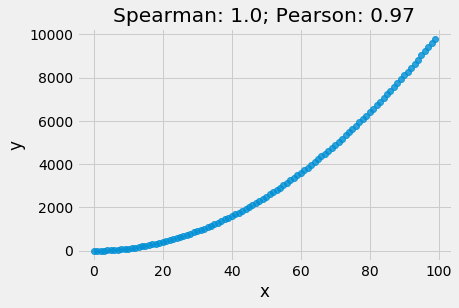

In [62]:
x = np.array(range(100))
y = x**2 

plot_corr(x,y)

The Spearman correlation is often considered to be better for ordinal variables such as the Target or the years of education. Most relationshisp in the real world aren't linear, and although the Pearson correlation can be an approximation of how related two variables are, it's inexact and not the best method of comparison.

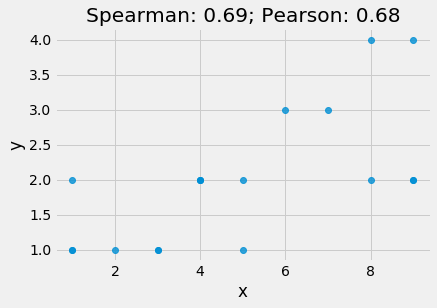

In [63]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corr(x, y)

대부분의 경우에 값은 매우 비슷합니다.

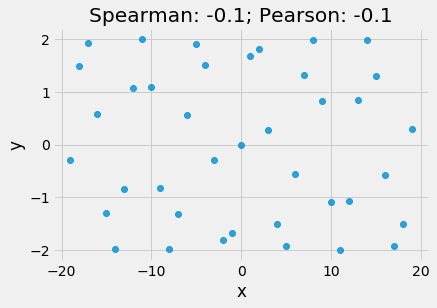

In [64]:
x = np.array(range(-19,20))
y = 2*np.sin(x)

plot_corr(x,y)

첫째로, 모든 변수에 피어슨 상관계수를 계산한다. 

In [65]:
#Use only training data 
train_heads = heads.loc[heads['Target'].notnull(),:].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target':'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index':'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\n Most positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

 Most positively correlated variables:
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


`warning` 이 증가하면 빈곤 단계 또한 증가한다. 왜냐하면 집에 대한 bad 싸인 또한 증가하기 때문이다.`hogar_nin`은 아이들 0 -19 나이를 나타낸다. 어린 아이들은 금융적인 스트레스를 준다. 혹은 낮은 ~ 상태의 가정들이 더 많은 아이들은 가진다.    
  
반면에, 긍정적인 상관관계에서, 높은 값은 높은 Target 값을 나타낸다. 가장 높은 관계 가정 변수는 `meaneduc`, 가정에서 어른들의 평균 교육수준, 이다.    

The general guidelines for correlation values are below, but these will change depending on who you ask (source for these):

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”  

이제 우리는 스피어만 상관관계를 계속 본다.  

In [66]:
import warnings 
warnings.filterwarnings('ignore',category=RuntimeWarning)

feats = [] 
scorr = [] 
pvalues = [] 

#Iterate through each column 
for c in heads :
    #Only valid for numbers 
    if heads[c].dtype != 'object' :
        feats.append(c)
        
        #Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c],train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c],train_heads['Target']).pvalue)
        
scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

스피어만 상관관계 상관계수 계산 또한 `pvalue`에서 온다. 어떤 `pvalue`든 0.05보다 낮으면 일반적으로 상당하다고 여겨진다. 비록 우리가 다수 비교를 해도. 우리는 p-value를 많은 비교로 나누고 싶고, 그 과정은 Bonferroni correction으로 알려졌다. 

In [67]:
print('Most negatice Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations ')
print(scorrs.dropna().tail())

Most negatice Spearman correlations:
       feature     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Most positive Spearman correlations 
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


In [68]:
corrs = pcorrs.merge(scorrs,on='feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [69]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


상관관계에서 가장 큰 차이는 는 `dependency`이다. 우리는 scatterplot of `Target` vs `dependency`를 그릴 수 있다. 

Text(0.5, 1, 'Target Vs Dependency')

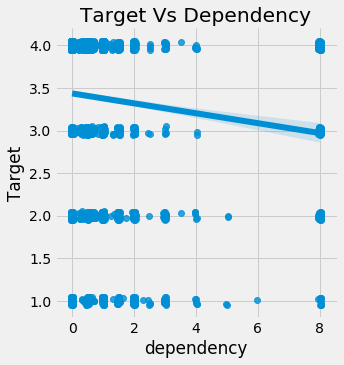

In [70]:
sns.lmplot('dependency','Target',fit_reg=True,data = train_heads,
          x_jitter=0.05, y_jitter=0.05)
plt.title('Target Vs Dependency')

관계를 보기 힘들지만 비교적 네거티브 합니다. `dependency`가 오를 수록 `Target` 값이 내려갑니다.     
 the dependency is the number of dependent individuals divided by the number of non-dependents. As we increase this value, the poverty severty tends to increase: having more dependent family members (who usually are non-working) leads to higher levels of poverty because they must be supported by the non-dependent family members.

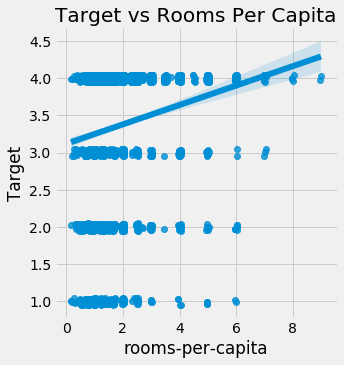

In [71]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

### Correlation Heatmap   
우리는 7개의 변수를 고르고 상관관계를 보입니다.  

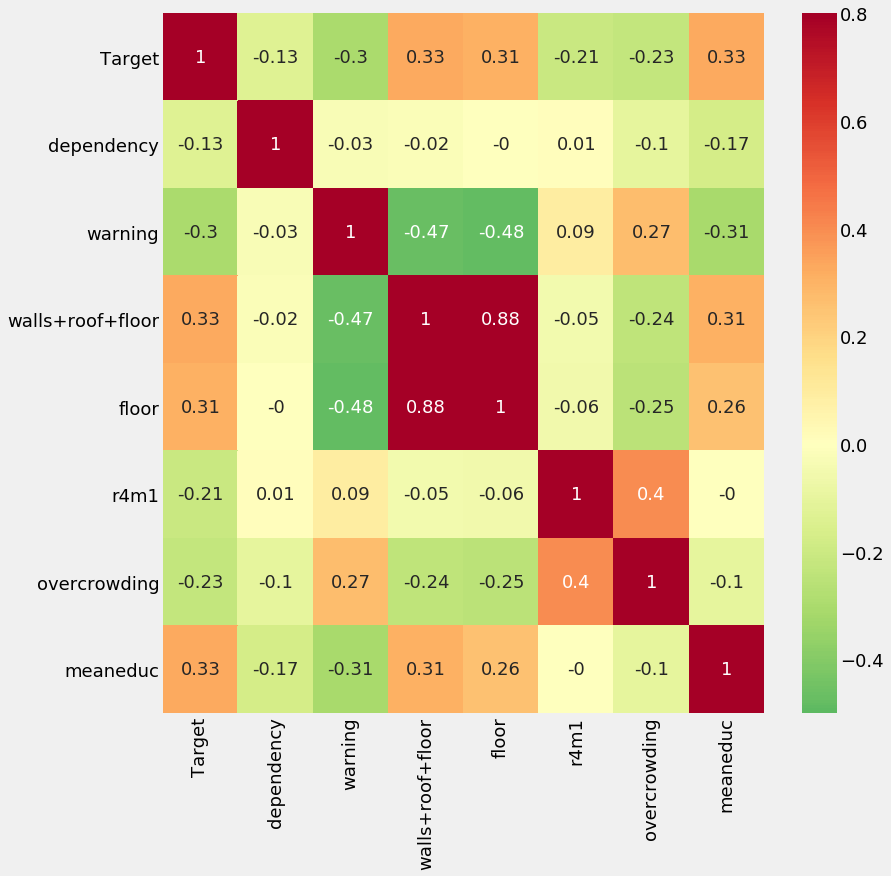

In [72]:
variables = ['Target','dependency','warning','walls+roof+floor',
            'floor','r4m1','overcrowding','meaneduc']

#Calculate the correlations 
corr_mat = train_heads[variables].corr().round(2)

#Draw a correlation heatmap
plt.rcParams['font.size'] = 18 
plt.figure(figsize=(12,12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True)

이 히트맵은 많은 변수들과 `Target` 관계를 보여줍니다. 가장 높은 상관관계는 `floor`, `walls+roof+floor`입니다. 

### Features Plot 
 we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate (kde) plots on the diagonal, and 2D KDE plots on the lower triangle.

Text(0.5, 1.05, 'Feature Plots Colored By Target')

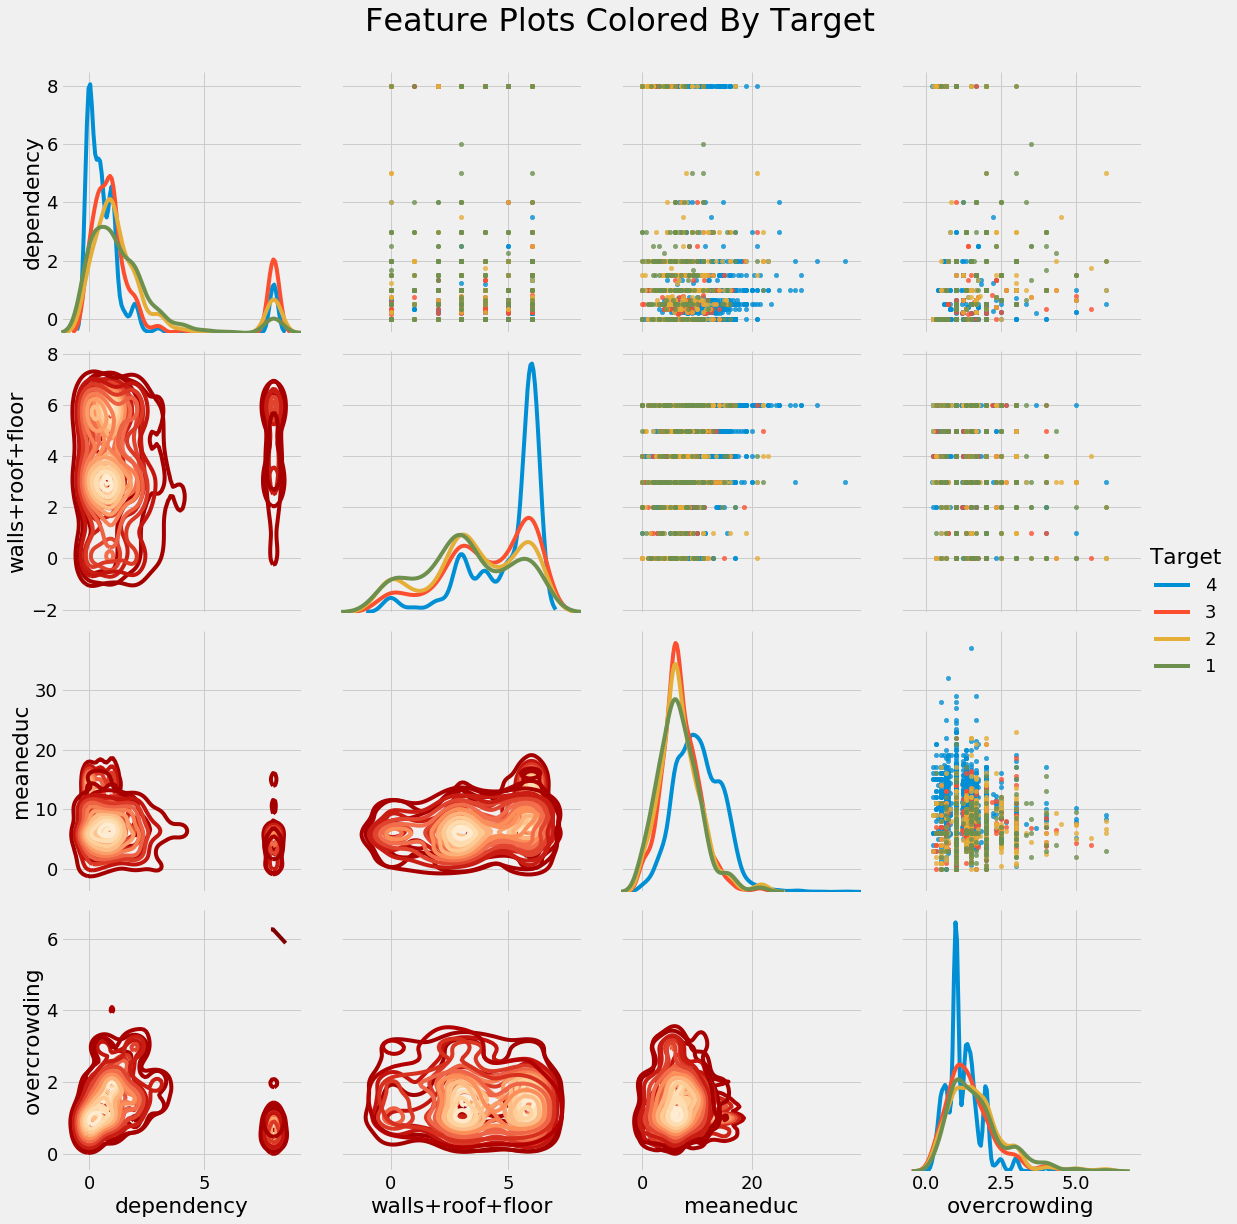

In [73]:
import warnings 
warnings.filterwarnings('ignore')

#Copy the data for plotting 
plot_data = train_heads[['Target','dependency','walls+roof+floor','meaneduc','overcrowding']]

#Create the pairgrid object 
grid = sns.PairGrid(data = plot_data, size = 4, diag_sharey=False,
                    hue = 'Target', hue_order = [4, 3, 2, 1], 
                    vars = [x for x in list(plot_data.columns)if x != 'Target'])

#Upper is a scatter plot 
grid.map_upper(plt.scatter,alpha = 0.8, s = 20)

#Diagonal is a histogram 
grid.map_diag(sns.kdeplot)

#Bottom is density plot 
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target',size = 32,y = 1.05)

우리는 지금 가정 변수 피처 엔지니어링을 마무리합니다.
나중에 다시 돌아와 마무리 짓겠습니다.

In [74]:
household_feats = list(heads.columns)

# Individual Level Variables 
2개의 individual level  타입이 있습니다.    
* Boolean (1 or 0/ True or False)
* ordinal(discrete valuew with meaningful ordering )

In [75]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Redundant Individual Variables 
우리는 household level 변수에 했던 것처럼 똑같이 individual variables에 합니다. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.

In [76]:
#Create correlation matrix 
corr_matrix = ind.corr()

#Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k = 1).astype(np.bool))

#Find index of feature columns with correlation geater than 0.95
to_drop =[column for column in upper.columns if any(abs(upper[column])>0.95)]

to_drop 

['female']

In [77]:
ind = ind.drop(columns = 'male')

### Creating Ordinal Variables 
우리는 `instlevel_` 변수(교육 양을 나타내는)를 `instlevel1`에서 가져왔습니다.    
ordinal 변수를 만들기 위해, 우리는 간단히 어떤 칼럼이 non-zero인지 찾습니다. 교육은 inherent ordering을 가지고 있으므로 ordinal변수로 변환합니다.?

In [78]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


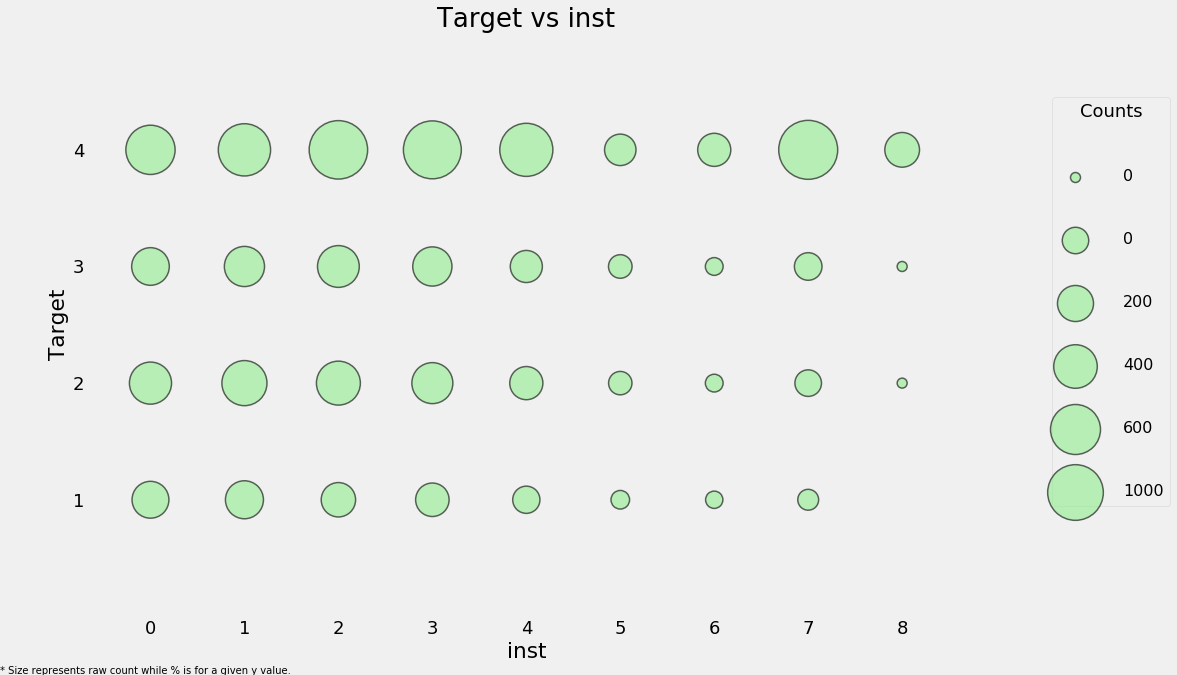

In [79]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]),axis = 1)

plot_categoricals('inst','Target',ind, annotate=False)

Higher levels of education seem to correspond to less extreme levels of poverty. We do need to keep in mind this is on an individual level though and we eventually will have to aggregate this data at the household level.

Text(0.5, 1.0, 'Education Distribution by Target')

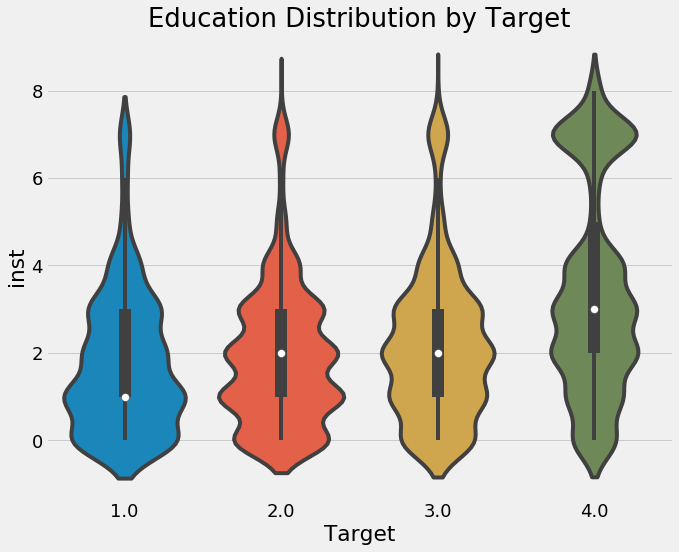

In [80]:
plt.figure(figsize = (10,8))
sns.violinplot(x = 'Target',y ='inst',data = ind)
plt.title('Education Distribution by Target')

In [81]:
# Drop the education columns
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 40)

### Feature Construction 
우리는 적은 피처를 기존 데이터를 이용해 만들 수 있습니다. 예를 들어, 우리는 나이에 따른 schooling을 나눌 수 있습니다. 

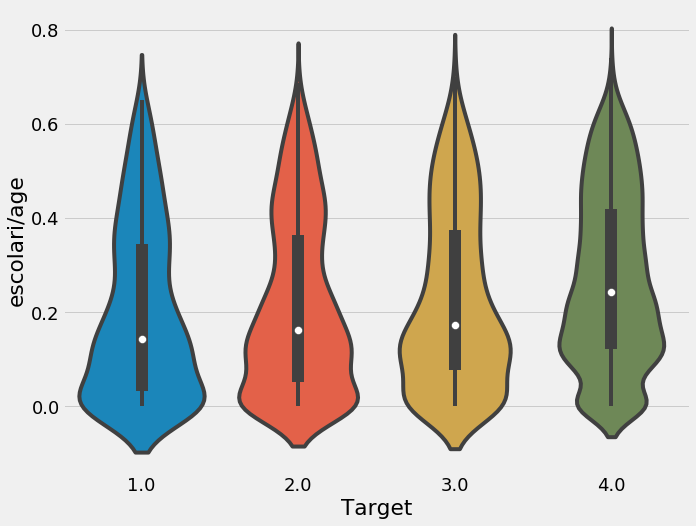

In [82]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize=(10,8))
sns.violinplot('Target','escolari/age',data=ind)

우리는 또한 새로운 변수를 만들수 있습니다. `inst` 그리고 나이로 나눌 수 있습니다. 최종 변수는 `tech`입니다. : 태블릿과 핸드폰의 조합을 나타내는 

In [83]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] / ind['mobilephone']
ind['tech'].describe()

count    32657.0
mean         inf
std          NaN
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          inf
Name: tech, dtype: float64

## Feature Engineering through Aggregations 
individual data를 household data로 통합하기 위해서, 우리는 각각 household를 통합합니다. 이 간단한 일을 하기위해서 `groupby` 한다. family id `idhogar` 과 `agg` .   

In [84]:
#Defin custom function
range_ = lambda x : x.max() - x.min()
range_.__name__ = 'range_'

#Group and aggregate 
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

우리는 30부터 180피처를 ~, 다음은 이름을 쉽게 추적할 수 있게 바꾼다. 

In [85]:
#Rename the columns 
new_col = [] 
for c in ind_agg.columns.levels[0] :
    for stat in ind_agg.columns.levels[1] :
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col 
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,instlevel5-count,instlevel5-std,instlevel5-range_,instlevel6-min,instlevel6-max,instlevel6-sum,instlevel6-count,instlevel6-std,instlevel6-range_,instlevel7-min,instlevel7-max,instlevel7-sum,instlevel7-count,instlevel7-std,instlevel7-range_,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-count,instlevel8-std,instlevel8-range_,instlevel9-min,instlevel9-max,instlevel9-sum,instlevel9-count,instlevel9-std,instlevel9-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,1.0,1.0,3.0,3,0.0,0.0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,0.0,0.0,0.0,2,0.0,0.0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.5,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,1,1,4,0.500000,1,0,0,0,4,0.0,0,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,0.0,0.0,0.0,4,0.0,0.0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2

In [86]:
ind_agg.iloc[:,[0,1,2,3,6,7,8,9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Feature Selection
모든 페어 변수들 중 하나를 지운다. 상관계수가 0.95보다 큰 

In [87]:
#Create correlation matrix 
corr_matrix = ind_agg.corr()

#Select upper traiangle of correlation matrix 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

#Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column])>0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 113 correlated columns to remove.


우리는 칼럼을 드랍하고 `heads` 데이터와 병합합니다. final df만들기 위해

In [88]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

#Merge in the household id 
final = heads.merge(ind_agg, on='idhogar',how = 'left')

print('Final features shape:',final.shape)

Final features shape: (10307, 226)


In [89]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,...,parentesco5-max,parentesco6-min,parentesco6-max,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,NaN,0,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,NaN,0.0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,NaN,0,0,1,NaN,0,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,NaN,0.0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,NaN,NaN
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,2,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,0.0,0.0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,1,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.

### Final Data Exploration 

In [90]:
corrs = final.corr()['Target']

In [91]:
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [92]:
corrs.sort_values().dropna().tail()

walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

매우 높은 상관관계를 가진 변수들을 볼 수 있습니다. 이 변수들이 실제로 _유용한지_ 아닌지는 modeling 단계에서 결정될 것입니다. 

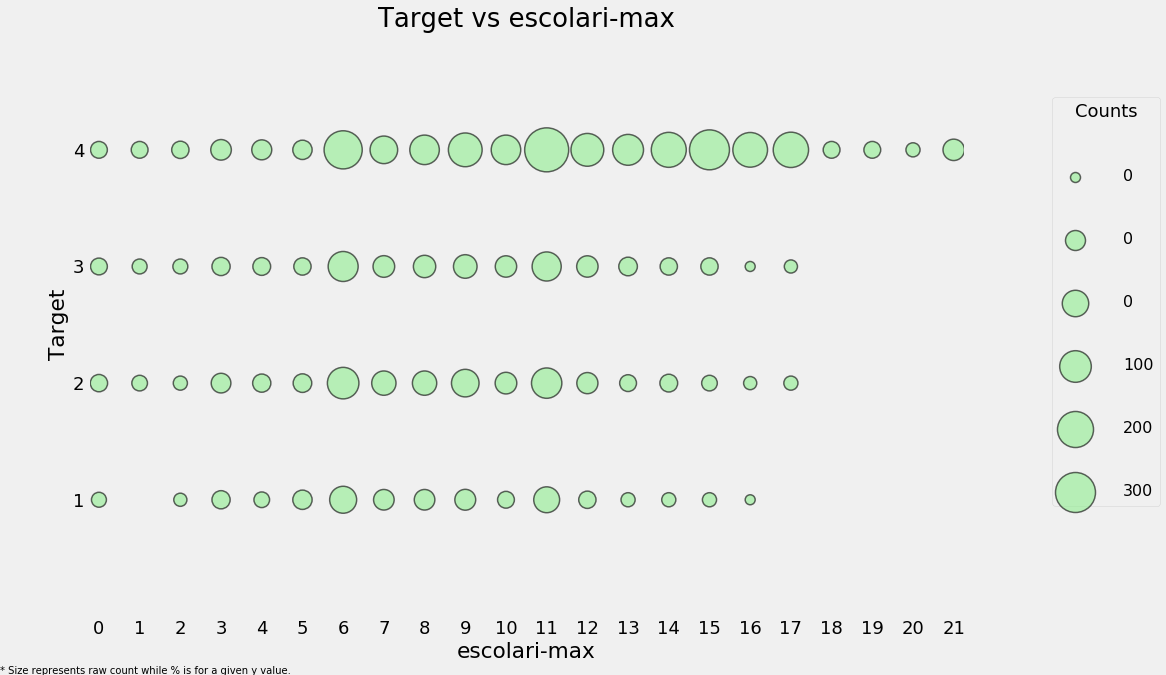

In [93]:
plot_categoricals('escolari-max','Target',final,annotate=False)

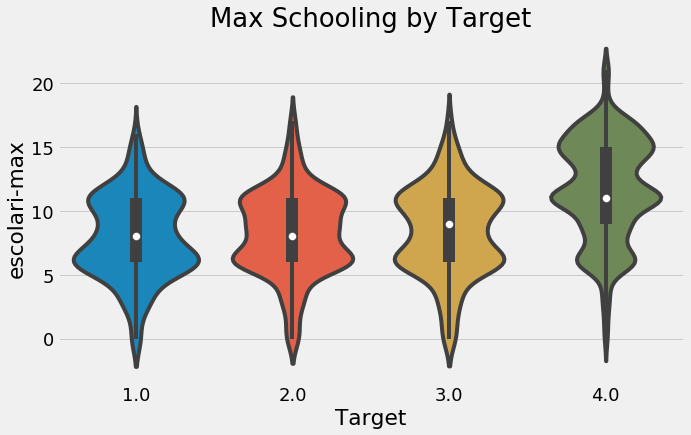

In [94]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

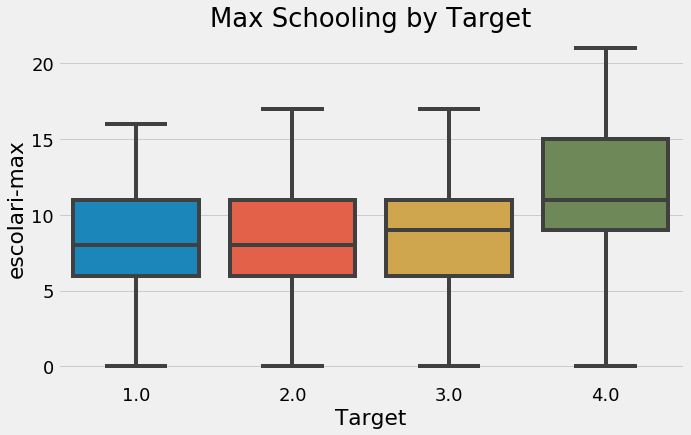

In [95]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

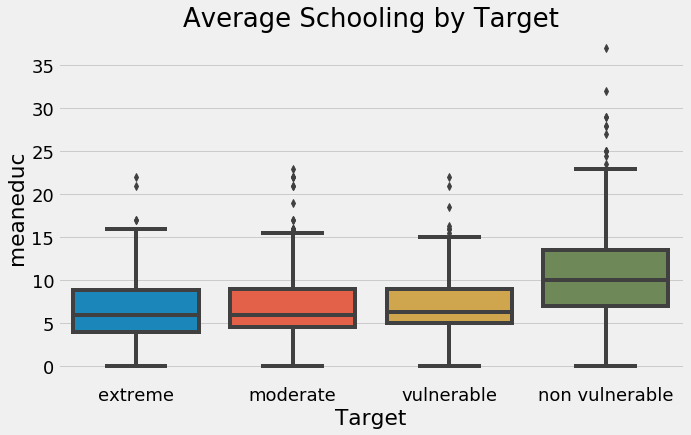

In [96]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target');

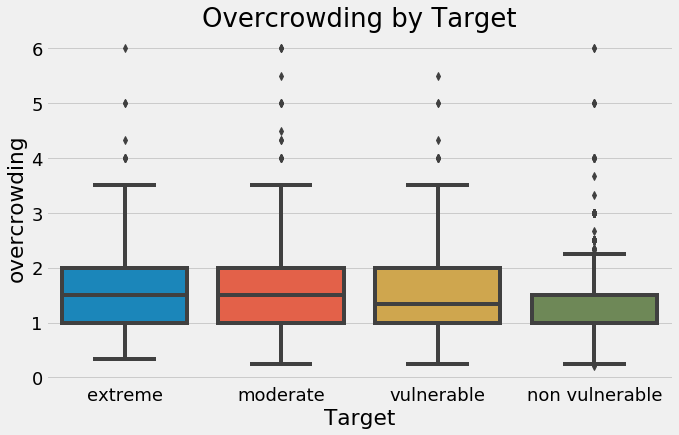

In [97]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target');

다른 변수들 중 유용한 것들 중 하나는 **가장의 성별** 입니다. 우리가 데이터를 병합했기 때문에, 우리는 개인 레벨로 되돌아가 가장의 성별을 찾아야 합니다. 

In [98]:
head_gender = ind.loc[ind['parentesco1']==1,['idhogar','female']]
final = final.merge(head_gender,on='idhogar',how='left').rename(columns = {'female': 'female-head'})

In [99]:
final.groupby('female-head')['Target'].value_counts(normalize = True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

It looks like households where the head is female are slightly more likely to have a severe level of poverty.

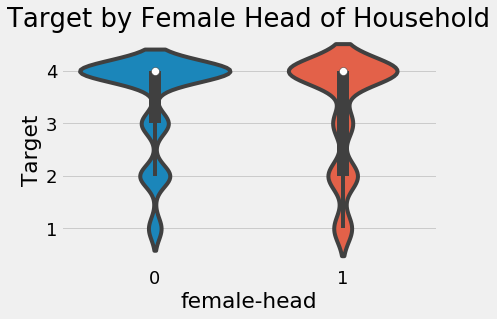

In [100]:
sns.violinplot(x = 'female-head', y = 'Target', data = final);
plt.title('Target by Female Head of Household');

We can also look at the difference in average education by whether or not the family has a female head of household.

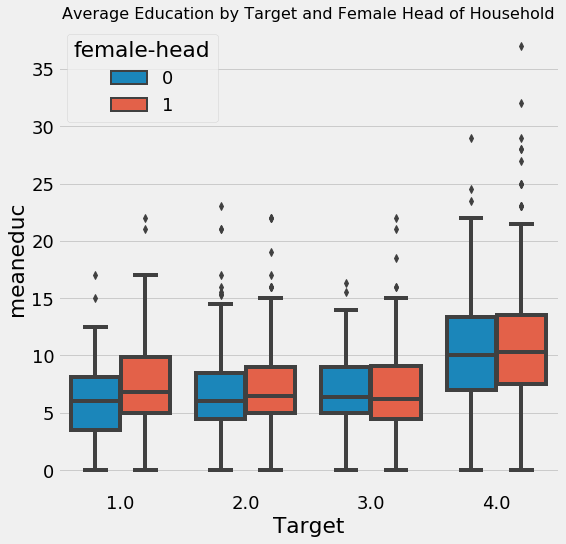

In [101]:
plt.figure(figsize = (8, 8))
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'female-head', data = final);
plt.title('Average Education by Target and Female Head of Household', size = 16);

`Target`의 모든 값과 비슷해보입니다. 여성가장은 더 높은 수준의 교육을 받았습니다. 그러나 전반적으로 여성가장이 좀 더 가난해보입니다. 

In [102]:
final.groupby('female-head')['meaneduc'].agg(['mean','count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


전반적으로, 여성 가장의 전반적인 교육 수준은 남성 가ㅓㅇ보다 조금 높습니다. 

# Machine Learning Modeling 

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

#Custom scorer for cross validation 
scorer = make_scorer(f1_score,greater_is_better=True, average='macro')

In [104]:
#Labels for training 
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

#Extract the training data 
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

#submission base 
submission_base = test[['Id','idhogar']].copy()

다른 모델을 비교할 것이기 때문에, 우리는 피처를 스케일링 해야 합니다. 많은 앙상블 모델은 꼭 필요하진 않지만 distance metric에 의존하는 모델을 쓰기 때문에 (KN 최적 이웃 or the support Vector Machine) 피쳐 스케일링은 절대적으로 필요합니다. 다른 모델을 비교할때, 스케일링 하는 것이 가장 안전합니다.   

For imputing missing values and scaling the features in one step, we can make a pipeline. This will be fit on the training data and used to transform the training and testing data.

In [105]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer',SimpleImputer(strategy='median')),
                    ('scaler',MinMaxScaler())])

#Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

the data has no missing values  
**so we can directly used any Scikit-Learn model**

In [106]:
model = RandomForestClassifier(n_estimators=100, random_state=10,n_jobs=-1)

# 10 fold cross validation
cv_score = cross_val_score(model, train_set,train_labels,cv=10, scoring=scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3515 with std = 0.0538


## Feature Importances 
tree 기반 모델로 우리는 피처 중요도를 볼것입니다.  These represent the sum of the reduction in impurity at nodes that used the variable for splitting, but we don't have to pay much attention to the absolute value. Instead we'll focus on relative scores.

In [107]:
model.fit(train_set,train_labels)

#Feature importances into a df
feature_importances =  pd.DataFrame({'feature': features,'importance':model.feature_importances_  })
feature_importances.head()

,feature,importance
0,hacdor,0.000691
1,hacapo,0.000421
2,v14a,0.000369
3,refrig,0.001682
4,paredblolad,0.005963


In [108]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df


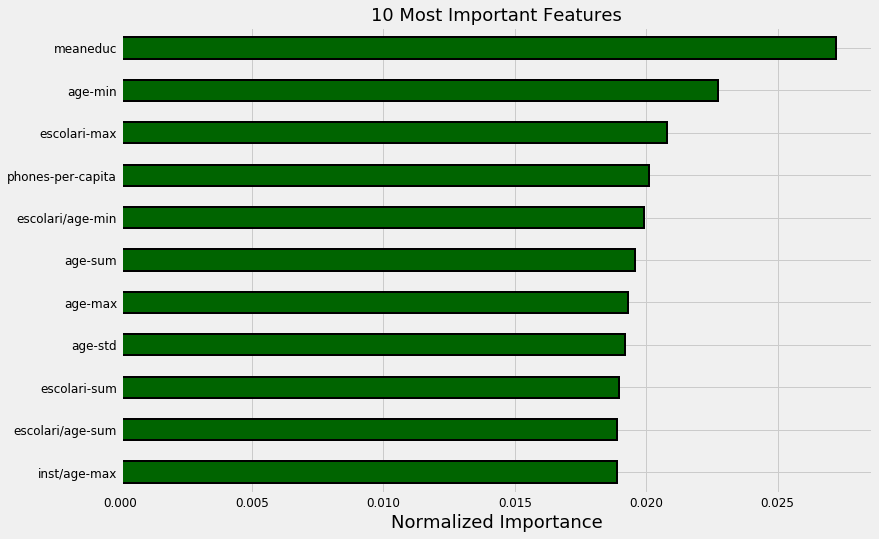

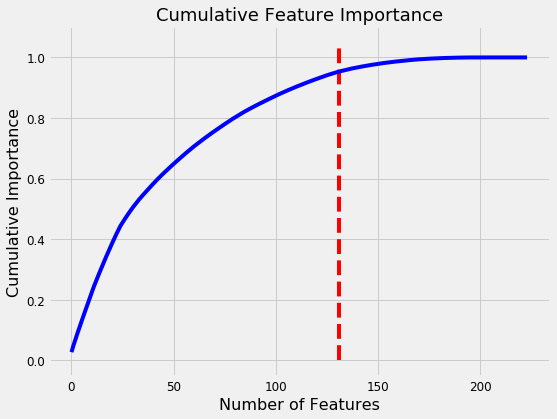

131 features required for 95% of cumulative importance.


In [109]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

가장 중요한 변수는 **가정의 교육 총량의 평균** 이다. 가정 누구든지간의 가장 큰 교육년수에 따른. 다른 높은 상관관계 변수들은 비슷하므로 지워도 된다.   
It's interesting that we only need 106 of the ~180 features to account for 90% of the importance. This tells us that we may be able to remove some of the features. However, feature importances don't tell us which direction of the feature is important (for example, we can't use these to tell whether more or less education leads to more severe poverty) they only tell us which features the model considered relevant.

In [110]:
def kde_target(df, variable) :
    colors = {1: 'red',2:'orange',3:'blue',4:'green'}
    
    plt.figure(figsize=(12,8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target']==level].copy()
        sns.kdeplot(subset[variable].dropna(),
                    label = f'Poverty Level : {level}',
                    color = colors[int(subset['Target'].unique())])
                    
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.title('{} Distribution'.format(variable.capitalize()))
                    

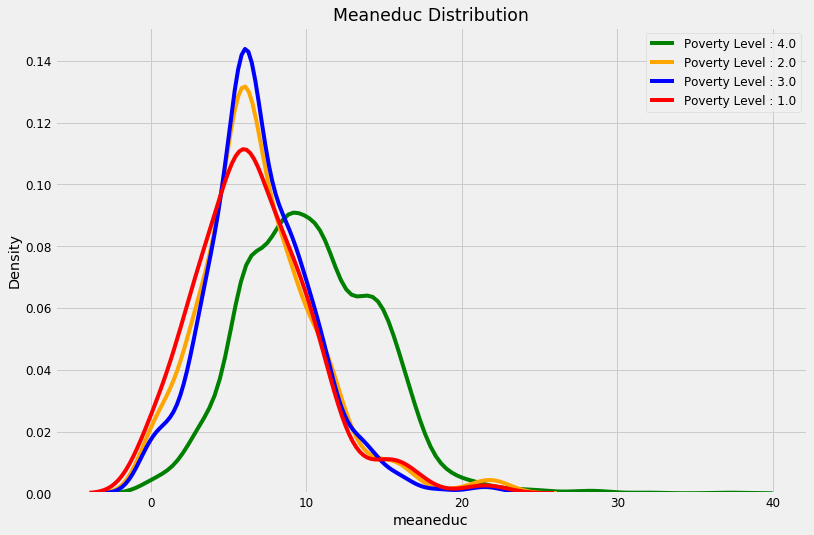

In [111]:
kde_target(final,'meaneduc')

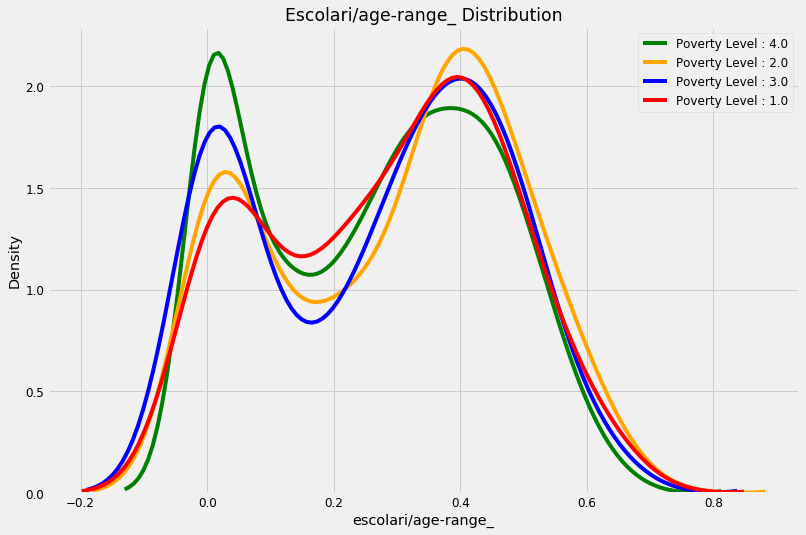

In [112]:
kde_target(final,'escolari/age-range_')

# Model Selection
이제 좋은 피처를 가졌으니 modeling을 시작하겠습니다. 우리는 이미 basic model을 시도했습니다.(랜덤 포레스트)    
대부분의 사람들은 결국 **gradient boosting machine**을 선택합니다. 우리도 시도하겠지만 현재는 다른 옵션을 선택합니다. 

What we want to do is write a function that can evaluate a model. This will be pretty simple since we already wrote most of the code. In addition to the Random Forest Classifier, we'll try eight other Scikit-Learn models. Luckily, this dataset is relatively small and we can rapidly iterate through the models. We will make a dataframe to hold the results and the function will add a row to the dataframe for each model.

In [113]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [114]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)


In [115]:
#DataFrame to hold results 
model_results = pd.DataFrame(columns=['model','cv_mean','cv_std'])

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [116]:
model_results = cv_model(train_set,train_labels,LinearSVC(),
                        'LSVC',model_results)

10 Fold CV Score: 0.2862 with std: 0.03949


In [117]:
model_results = cv_model(train_set,train_labels,
                        GaussianNB(),'GNB',model_results)

10 Fold CV Score: 0.18489 with std: 0.03674


In [118]:
model_results = cv_model(train_set,train_labels,
                        MLPClassifier(),
                        'MLP',model_results)

10 Fold CV Score: 0.29474 with std: 0.05052


In [119]:
model_results =cv_model(train_set, train_labels,
                       LinearDiscriminantAnalysis(),
                       'LDA',model_results)

10 Fold CV Score: 0.31531 with std: 0.06166


In [120]:
model_results = cv_model(train_set, train_labels,
                        RidgeClassifierCV(),'RIDGE',model_results)

10 Fold CV Score: 0.27814 with std: 0.03414


In [121]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.35015 with std: 0.03788

KNN with 10 neighbors

10 Fold CV Score: 0.3175 with std: 0.03276

KNN with 20 neighbors

10 Fold CV Score: 0.301 with std: 0.0468


선형회귀가 잘 돌아가고 그것보단 tree가 더 잘 돌아간다. 

In [122]:
from sklearn.ensemble import ExtraTreesClassifier 

model_results = cv_model(train_set, train_labels,
                        ExtraTreesClassifier(n_estimators=100),'EXT',model_results)

10 Fold CV Score: 0.33768 with std: 0.04461


## Comparing Model Performance

어떤 모델이 제일 잘하나 볼까요?

In [123]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.35148 with std: 0.05385


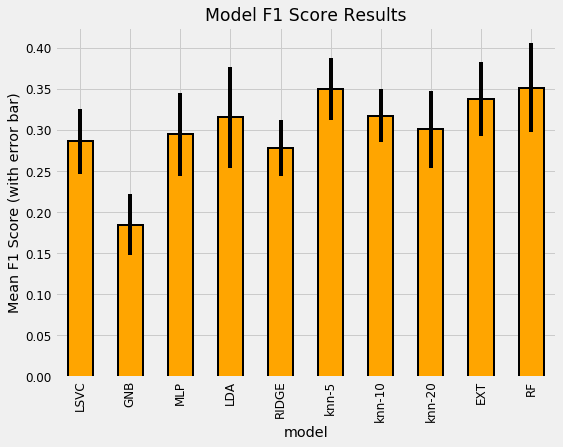

In [124]:
model_results.set_index('model',inplace=True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

랜덤 포레스트가 성능이 제일 좋게 나왔다. 우리는 하이퍼파라미터 조정을 안했기 때문에 비교는 정확하지 않다. 

# Making a Submission 

The format of a testing submission is shown below. Although we are making predictions for each household, we actually need one row per individual (identified by the Id) but only the prediction for the head of household is scored.
>Id,Target   
ID_2f6873615,1     
ID_1c78846d2,2  
ID_e5442cf6a,3   
ID_a8db26a79,4   
ID_a62966799,4   



In [125]:
test_ids = list(final.loc[final['Target'].isnull(),'idhogar'])

* Trains the model on the training data using `fit`
* Makes predictions on the test data using `predict`
* Creates a `submission` dataframe that can be saved and uploaded to the competition

In [126]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [127]:
#랜덤 포레스트 돌려보자~ 
rf_submission = submit(RandomForestClassifier(n_estimators=100,
                                             random_state=10,n_jobs=-1),
                      train_set, train_labels,test_set,test_ids)
rf_submission.to_csv('rf_submission.csv', index = False)

예측 결과는 **0.370**이 나왓다

# Feature Selection 


In [128]:
train_set = pd.DataFrame(train_set, columns = features)

# Create correlation matrix
corr_matrix = train_set.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [129]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

(2973, 220)

In [130]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

## Recursive Feature Elimination with RandomForest 

In [131]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

In [132]:
selector.fit(train_set, train_labels)

RFECV(cv=3,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=10,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1,
      scoring=make_scorer(f1_score, average=macro), step=1, verbose=0)

65

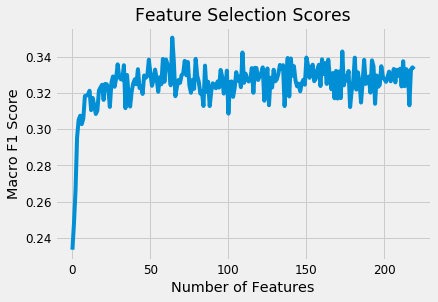

In [133]:
plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

In [134]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

,feature,rank
109,female-std,1
65,v2a1,1
95,bonus,1
96,phones-per-capita,1
98,rooms-per-capita,1
99,rent-per-capita,1
57,lugar1,1
66,dependency,1
49,eviv3,1
91,roof,1


In [135]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [136]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [137]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.35699 with std: 0.03807


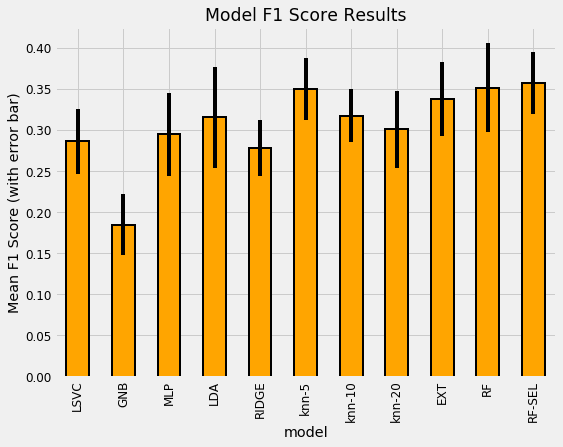

In [138]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

# Upgrading Our Model : Gradient Boosting Machine 